# Analyzing how coherence scales with model size

## Importing libraries and loading data

In [1]:
from src.analyzer import Analyzer
from src.visualizer import VisualisationConfig, visualize
from src.metrics import pairwise_bce_of_group, nbce_of_group, cbc_of_group, scs_of_group, rbc_of_group
import altair as alt
import numpy as np
import pandas as pd

alt.data_transformers.enable("vegafusion")

logprob_data_paths = ["data/logprobs_part1.csv", "data/logprobs_part2.csv"]

# merge logprobs.csv and pythia_logprobs.csv

logprobs = [pd.read_csv(logprob_data_path) for logprob_data_path in logprob_data_paths]


# merge the two dataframes
logprobs = pd.concat(logprobs)
logprobs.reset_index(drop=True, inplace=True)


data_analyzer = Analyzer(logprobs)
data_analyzer.df

,item_index,class_category,class,class_elicitation,evidence_text,evidence_elicitation,conversation_history,model_name,model_provider,temperature,...,posterior_prob,prior_prompt,likelihood_prompt,posterior_prompt,prior_full_text,likelihood_full_text,posterior_full_text,prior_token_logprobs,likelihood_token_logprobs,posterior_token_logprobs
0,0,formula_1_drivers,Lewis Hamilton.,My favourite Formula 1 driver is,a record-tying number of world championships ...,I am most impressed by,We've been analyzing famous athletes and how t...,meta-llama/Llama-3.1-8B,hf,1.0,...,0.064653,We've been analyzing famous athletes and how t...,We've been analyzing famous athletes and how t...,We've been analyzing famous athletes and how t...,We've been analyzing famous athletes and how t...,We've been analyzing famous athletes and how t...,We've been analyzing famous athletes and how t...,"[-1.2950670719146729, -0.008770634420216084, -...","[-6.217564105987549, -6.68656063079834, -7.278...","[-1.5588836669921875, -0.008721711114048958, -..."
1,0,formula_1_drivers,Lewis Hamilton.,My favourite Formula 1 driver is,breathtaking qualifying laps and legendary we...,I am most impressed by,We've been analyzing famous athletes and how t...,meta-llama/Llama-3.1-8B,hf,1.0,...,0.022107,We've been analyzing famous athletes and how t...,We've been analyzing famous athletes and how t...,We've been analyzing famous athletes and how t...,We've been analyzing famous athletes and how t...,We've been analyzing famous athletes and how t...,We've been analyzing famous athletes and how t...,"[-1.2950670719146729, -0.008770634420216084, -...","[-17.018823623657227, -7.016323089599609, -1.0...","[-2.4445810317993164, -0.008835033513605595, -..."
2,0,formula_1_drivers,Lewis Hamilton.,My favourite Formula 1 driver is,strategic championship battles with rivals ac...,I am most impressed by,We've been analyzing famous athletes and how t...,meta-llama/Llama-3.1-8B,hf,1.0,...,0.034644,We've been analyzing famous athletes and how t...,We've been analyzing famous athletes and how t...,We've been analyzing famous athletes and how t...,We've been analyzing famous athletes and how t...,We've been analyzing famous athletes and how t...,We've been analyzing famous athletes and how t...,"[-1.2950670719146729, -0.008770634420216084, -...","[-14.231816291809082, -8.730987548828125, -3.9...","[-2.106292247772217, -0.0070099132135510445, -..."
3,0,formula_1_drivers,Lewis Hamilton.,My favourite Formula 1 driver is,dominant performances in the turbo-hybrid era.,I am most impressed by,We've been analyzing famous athletes and how t...,meta-llama/Llama-3.1-8B,hf,1.0,...,0.073508,We've been analyzing famous athletes and how t...,We've been analyzing famous athletes and how t...,We've been analyzing famous athletes and how t...,We've been analyzing famous athletes and how t...,We've been analyzing famous athletes and how t...,We've been analyzing famous athletes and how t...,"[-1.2950670719146729, -0.008770634420216084, -...","[-11.61587905883789, -2.5253348350524902, -2.0...","[-1.3492863178253174, -0.01128622516989708, -1..."
4,0,formula_1_drivers,Lewis Hamilton.,My favourite Formula 1 driver is,the youngest ever Formula 1 world champion.,I am most impressed by,We've been analyzing famous athletes and how t...,meta-llama/Llama-3.1-8B,hf,1.0,...,0.130401,We've been analyzing famous athletes and how t...,We've been analyzing famous athletes and how t...,We've been analyzing famous athletes and how t...,We've been analyzing famous athletes and how t...,We've been analyzing famous athletes and how t...,We've been analyzing famous athletes and how t...,"[-1.2950670719146729, -0.008770634420216084, -...","[-2.0232248306274414, -9.38841724395752, -2.04...","[-1.1226575374603271, -0.02211189828813076, -0..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
106585,9,airlines,Qantas.,I usually fly with,SkyTeam membership with access to a large par...,I prefer an airline

In [2]:
data_analyzer.df.columns

Index(['item_index', 'class_category', 'class', 'class_elicitation',
       'evidence_text', 'evidence_elicitation', 'conversation_history',
       'model_name', 'model_provider', 'temperature', 'device', 'model_params',
       'model_kwargs', 'prior_logprob', 'likelihood_logprob',
       'posterior_logprob', 'prior_num_tokens', 'likelihood_num_tokens',
       'posterior_num_tokens', 'prior_prob', 'likelihood_prob',
       'posterior_prob', 'prior_prompt', 'likelihood_prompt',
       'posterior_prompt', 'prior_full_text', 'likelihood_full_text',
       'posterior_full_text', 'prior_token_logprobs',
       'likelihood_token_logprobs', 'posterior_token_logprobs'],
      dtype='object')

## Renaming columns, models and adding model family and size columns

In [3]:
np.unique(data_analyzer.df["model_name"]), np.unique(data_analyzer.df["model_kwargs"])

(array(['EleutherAI/pythia-12b', 'EleutherAI/pythia-160m',
        'EleutherAI/pythia-1b', 'EleutherAI/pythia-6.9b',
        'Qwen/Qwen2.5-14B', 'Qwen/Qwen2.5-3B', 'Qwen/Qwen2.5-7B',
        'deepseek-ai/DeepSeek-R1-Distill-Qwen-14B',
        'meta-llama/Llama-3.1-8B', 'meta-llama/Llama-3.2-1B',
        'meta-llama/Llama-3.2-3B', 'microsoft/phi-4',
        'mistralai/Mistral-Nemo-Base-2407', 'openai-community/gpt2',
        'openai-community/gpt2-large', 'openai-community/gpt2-medium',
        'openai-community/gpt2-xl', 'tiiuae/Falcon3-10B-Base',
        'tiiuae/Falcon3-1B-Base', 'tiiuae/Falcon3-3B-Base',
        'tiiuae/Falcon3-7B-Base'], dtype=object),
 array(['{"revision": "step143000"}', '{"revision": "step33000"}',
        '{"revision": "step66000"}', '{"revision": "step99000"}', '{}'],
       dtype=object))

In [4]:
# evals from open-llm-leaderboard
evals_df = pd.read_parquet(
    "hf://datasets/open-llm-leaderboard/contents/data/train-00000-of-00001.parquet"
)
evals_df.columns

/opt/anaconda3/envs/llm-bayes/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Index(['eval_name', 'Precision', 'Type', 'T', 'Weight type', 'Architecture',
       'Model', 'fullname', 'Model sha', 'Average ⬆️', 'Hub License', 'Hub ❤️',
       '#Params (B)', 'Available on the hub', 'MoE', 'Flagged',
       'Chat Template', 'CO₂ cost (kg)', 'IFEval Raw', 'IFEval', 'BBH Raw',
       'BBH', 'MATH Lvl 5 Raw', 'MATH Lvl 5', 'GPQA Raw', 'GPQA', 'MUSR Raw',
       'MUSR', 'MMLU-PRO Raw', 'MMLU-PRO', 'Merged', 'Official Providers',
       'Upload To Hub Date', 'Submission Date', 'Generation', 'Base Model'],
      dtype='object')

In [5]:
data_analyzer.rename({"model_name": "Language Model", "model_kwargs": "Training Steps"})

params_lookup = (

    evals_df.drop_duplicates(subset=["fullname"])
    .set_index("fullname")["#Params (B)"]
    .to_dict()
)

# Add the '#Params (B)' column to data_analyzer.df
data_analyzer.add_column(
    column_name="#Params (B)",
    column_spec=lambda df: df["Language Model"]
    .map(params_lookup)
    .astype(float),  # Ensure it's float for numerical operations
)

selected_evals = [
    "IFEval",
    "BBH",
    "MATH Lvl 5",
    "GPQA",
    "MUSR",
    "MMLU-PRO",
    "MMLU-PRO",
    "Average ⬆️",
]

# Create a lookup dictionary once for efficiency
eval_lookup = {}
for model_name in evals_df["fullname"].unique():
    eval_lookup[model_name] = {
        eval_name: evals_df[evals_df["fullname"] == model_name][eval_name].iloc[0]
        for eval_name in selected_evals
        if not evals_df[evals_df["fullname"] == model_name].empty
    }

# Add columns using direct dictionary lookups
for eval in selected_evals:
    data_analyzer.add_column(
        column_name=eval,
        column_spec=lambda df, eval_name=eval: df["Language Model"].map(
            lambda model: eval_lookup.get(model, {}).get(eval_name, np.nan)
        ),
    )

data_analyzer.add_column(
    column_name="Model Family",
    column_spec=(
        {"Language Model": lambda model_name: model_name.split("/")[1].split("-")[0]}
    ),
)


def format_model_kwargs(kwarg_str):
    if '"revision": "step' in kwarg_str:
        # Extract the step number
        step = kwarg_str.split("step")[1].split('"')[0]
        # Convert to k format (e.g., 33000 -> 33k)
        step_k = str(int(step) // 1000) + "k"
        return step_k
    else:
        return "unknown"

data_analyzer.rename(
    {
        "Model Family": {
            "Llama": "Llama 3",
            "gpt2": "GPT 2",
            "pythia": "Pythia",
            "Qwen2.5": "Qwen 2.5",
            "Falcon3": "Falcon 3",
        },
        "Language Model": lambda model_name: model_name.split("/")[1],
        "Training Steps": format_model_kwargs,
    }
)

data_analyzer.filter({"Model Family": ["Llama 3", "GPT 2", "Pythia", "Qwen 2.5", "Falcon 3"], "Training Steps": ["unknown", "143k"]})

data_analyzer.df

,item_index,class_category,class,class_elicitation,evidence_text,evidence_elicitation,conversation_history,Language Model,model_provider,temperature,...,posterior_token_logprobs,#Params (B),IFEval,BBH,MATH Lvl 5,GPQA,MUSR,MMLU-PRO,Average ⬆️,Model Family
0,0,formula_1_drivers,Lewis Hamilton.,My favourite Formula 1 driver is,a record-tying number of world championships ...,I am most impressed by,We've been analyzing famous athletes and how t...,Llama-3.1-8B,hf,1.0,...,"[-1.5588836669921875, -0.008721711114048958, -...",8.03,12.459829,25.304471,6.570997,8.053691,8.715104,25.421099,14.420865,Llama 3
1,0,formula_1_drivers,Lewis Hamilton.,My favourite Formula 1 driver is,breathtaking qualifying laps and legendary we...,I am most impressed by,We've been analyzing famous athletes and how t...,Llama-3.1-8B,hf,1.0,...,"[-2.4445810317993164, -0.008835033513605595, -...",8.03,12.459829,25.304471,6.570997,8.053691,8.715104,25.421099,14.420865,Llama 3
2,0,formula_1_drivers,Lewis Hamilton.,My favourite Formula 1 driver is,strategic championship battles with rivals ac...,I am most impressed by,We've been analyzing famous athletes and how t...,Llama-3.1-8B,hf,1.0,...,"[-2.106292247772217, -0.0070099132135510445, -...",8.03,12.459829,25.304471,6.570997,8.053691,8.715104,25.421099,14.420865,Llama 3
3,0,formula_1_drivers,Lewis Hamilton.,My favourite Formula 1 driver is,dominant performances in the turbo-hybrid era.,I am most impressed by,We've been analyzing famous athletes and how t...,Llama-3.1-8B,hf,1.0,...,"[-1.3492863178253174, -0.01128622516989708, -1...",8.03,12.459829,25.304471,6.570997,8.053691,8.715104,25.421099,14.420865,Llama 3
4,0,formula_1_drivers,Lewis Hamilton.,My favourite Formula 1 driver is,the youngest ever Formula 1 world champion.,I am most impressed by,We've been analyzing famous athletes and how t...,Llama-3.1-8B,hf,1.0,...,"[-1.1226575374603271, -0.02211189828813076, -0...",8.03,12.459829,25.304471,6.570997,8.053691,8.715104,25.421099,14.420865,Llama 3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
103355,9,airlines,Qantas.,I usually fly with,SkyTeam membership with access to a large par...,I prefer an airline that offers,We also talked about how different airlines ha...,pythia-12b,hf,1.0,...,"[-4.73833703994751, -0.02424274943768978, -3.0...",12.00,24.714757,4.987531,1.661631,0.000000,3.787240,1.207890,6.059841,Pythia
103356,9,airlines,Qantas.,I usually fly with,historic roots as a flag carrier representing...,I prefer an airline that offers,We also talked about how different airlines ha...,pythia-12b,hf,1.0,...,"[-6.370099067687988, -0.033004920929670334, -4...",12.00,24.714757,4.987531,1.661631,0.000000,3.787240,1.207890,6.059841,Pythia
103357,9,airlines,Qantas.,I usually fly with,a strong presence serving cities across North...,I prefer an airline that offers,We also talked about how different airlines ha...,pythia-12b,hf,1.0,...,"[-3.792026996612549, -0.019088616594672203, -3...",12.00,24.714757,4.987531,1.661631,0.000000,3.787240,1.207890,6.059841,Pythia
103358,9,airlines,Qantas.,I usually fly with,fast Wi-Fi and a generous baggage allowance.,I prefer an airline that offers,We also talked about how different airlines ha...,pythia-12b,hf,1.0,...,"[-5.20582914352417, -0.007504486478865147, -3....",12.00,24.714757,4.987531,1.661631,0.000000,3.787240,1.207890,6.059841,Pythia


## Calculating All Coherence Metrics

We calculate all coherence metrics systematically using the same grouping strategy. We always group by evidence_text since different class types have different class and evidence elicitation prefixes.

The calculate_metric functions return Analyzer objects rather than modifying the dataframe in place, allowing us to chain operations.

In [6]:
data_analyzer.df.columns

Index(['item_index', 'class_category', 'class', 'class_elicitation',
       'evidence_text', 'evidence_elicitation', 'conversation_history',
       'Language Model', 'model_provider', 'temperature', 'device',
       'model_params', 'Training Steps', 'prior_logprob', 'likelihood_logprob',
       'posterior_logprob', 'prior_num_tokens', 'likelihood_num_tokens',
       'posterior_num_tokens', 'prior_prob', 'likelihood_prob',
       'posterior_prob', 'prior_prompt', 'likelihood_prompt',
       'posterior_prompt', 'prior_full_text', 'likelihood_full_text',
       'posterior_full_text', 'prior_token_logprobs',
       'likelihood_token_logprobs', 'posterior_token_logprobs', '#Params (B)',
       'IFEval', 'BBH', 'MATH Lvl 5', 'GPQA', 'MUSR', 'MMLU-PRO', 'Average ⬆️',
       'Model Family'],
      dtype='object')

In [7]:
from src.metrics import pairwise_ratios_and_averages

metrics_analyzer = data_analyzer.calculate_metric(
    metric_func=pairwise_ratios_and_averages,
    group_by_cols=["Language Model", "Training Steps", "evidence_text", "conversation_history", "class_category"],
    inherit_identical_values=True,
    log_prior_col="prior_logprob",
    log_likelihood_col="likelihood_logprob",
    log_posterior_col="posterior_logprob",
)

sort_config = {
    "#Params (B)": lambda x: x,
    "likelihood_num_tokens": lambda x: x,
    "Training Steps": ["33k", "66k", "99k", "143k", "unknown"],
}

metrics_analyzer.sort(sort_config)
metrics_analyzer.df

,Language Model,Training Steps,evidence_text,conversation_history,class_category,level_5,log_prior_ratio,log_likelihood_ratio,log_posterior_ratio,log_prior_avg,...,posterior_prompt,#Params (B),IFEval,BBH,MATH Lvl 5,GPQA,MUSR,MMLU-PRO,Average ⬆️,Model Family
64950,gpt2,unknown,absolutely nothing.,"Last time, we explored how external events inf...",state_of_mind,0,1.534722,-1.456150,0.554717,-9.969587,...,"Last time, we explored how external events inf...",0.137,17.925327,2.674981,0.226586,1.118568,15.348177,1.771203,6.510807,GPT 2
64951,gpt2,unknown,absolutely nothing.,"Last time, we explored how external events inf...",state_of_mind,1,0.528388,-0.714252,0.486298,-9.466420,...,"Last time, we explored how external events inf...",0.137,17.925327,2.674981,0.226586,1.118568,15.348177,1.771203,6.510807,GPT 2
64952,gpt2,unknown,absolutely nothing.,"Last time, we explored how external events inf...",state_of_mind,2,2.855020,-0.824902,3.190578,-10.629735,...,"Last time, we explored how external events inf...",0.137,17.925327,2.674981,0.226586,1.118568,15.348177,1.771203,6.510807,GPT 2
64953,gpt2,unknown,absolutely nothing.,"Last time, we explored how external events inf...",state_of_mind,3,3.551955,-0.204582,4.123702,-10.978203,...,"Last time, we explored how external events inf...",0.137,17.925327,2.674981,0.226586,1.118568,15.348177,1.771203,6.510807,GPT 2
64954,gpt2,unknown,absolutely nothing.,"Last time, we explored how external events inf...",state_of_mind,4,-1.006334,0.741898,-0.068419,-10.233781,...,"Last time, we explored how external events inf...",0.137,17.925327,2.674981,0.226586,1.118568,15.348177,1.771203,6.510807,GPT 2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
46365,Qwen2.5-14B,unknown,buildings found in many commercial city cente...,We have been reviewing how different regions i...,architectural_styles,5,5.057233,-3.398716,0.421274,-8.962322,...,We have been reviewing how different regions i...,14.770,36.944640,45.078312,29.003021,17.561521,15.913281,47.205600,31.951063,Qwen 2.5
46366,Qwen2.5-14B,unknown,buildings found in many commercial city cente...,We have been reviewing how different regions i...,architectural_styles,6,-0.211288,-11.553413,-10.199777,-6.328062,...,We have been reviewing how different regions i...,14.770,36.944640,45.078312,29.003021,17.561521,15.913281,47.205600,31.951063,Qwen 2.5
46367,Qwen2.5-14B,unknown,buildings found in many commercial city cente...,We have been reviewing how different regions i...,architectural_styles,7,2.477357,4.763157,3.257729,-10.252261,...,We have been reviewing how different regions i...,14.770,36.944640,45.078312,29.003021,17.561521,15.913281,47.205600,31.951063,Qwen 2.5
46368,Qwen2.5-14B,unknown,buildings found in many commercial city cente...,We have been reviewing how different regions i...,architectural_styles,8,-2.791165,-3.391541,-7.363323,-7.618000,...,We have been reviewing how different regions i...,14.770,36.944640,45.078312,29.003021,17.561521,15.913281,47.205600,31.951063,Qwen 2.5


In [8]:
metrics_analyzer.df.columns

Index(['Language Model', 'Training Steps', 'evidence_text',
       'conversation_history', 'class_category', 'level_5', 'log_prior_ratio',
       'log_likelihood_ratio', 'log_posterior_ratio', 'log_prior_avg',
       'log_likelihood_avg', 'log_posterior_avg', 'item_index',
       'class_elicitation', 'evidence_elicitation', 'model_provider',
       'temperature', 'device', 'model_params', 'likelihood_num_tokens',
       'prior_prompt', 'posterior_prompt', '#Params (B)', 'IFEval', 'BBH',
       'MATH Lvl 5', 'GPQA', 'MUSR', 'MMLU-PRO', 'Average ⬆️', 'Model Family'],
      dtype='object')

In [9]:
from src.metrics import log_odds_update

metrics_analyzer = metrics_analyzer.calculate_metric(
    metric_name="log_odds_update",
    metric_func=log_odds_update,
    log_prior_ratio_col="log_prior_ratio",
    log_posterior_ratio_col="log_posterior_ratio",
)

metrics_analyzer.df

,Language Model,Training Steps,evidence_text,conversation_history,class_category,level_5,log_prior_ratio,log_likelihood_ratio,log_posterior_ratio,log_prior_avg,...,#Params (B),IFEval,BBH,MATH Lvl 5,GPQA,MUSR,MMLU-PRO,Average ⬆️,Model Family,log_odds_update
64950,gpt2,unknown,absolutely nothing.,"Last time, we explored how external events inf...",state_of_mind,0,1.534722,-1.456150,0.554717,-9.969587,...,0.137,17.925327,2.674981,0.226586,1.118568,15.348177,1.771203,6.510807,GPT 2,-0.980005
64951,gpt2,unknown,absolutely nothing.,"Last time, we explored how external events inf...",state_of_mind,1,0.528388,-0.714252,0.486298,-9.466420,...,0.137,17.925327,2.674981,0.226586,1.118568,15.348177,1.771203,6.510807,GPT 2,-0.042090
64952,gpt2,unknown,absolutely nothing.,"Last time, we explored how external events inf...",state_of_mind,2,2.855020,-0.824902,3.190578,-10.629735,...,0.137,17.925327,2.674981,0.226586,1.118568,15.348177,1.771203,6.510807,GPT 2,0.335559
64953,gpt2,unknown,absolutely nothing.,"Last time, we explored how external events inf...",state_of_mind,3,3.551955,-0.204582,4.123702,-10.978203,...,0.137,17.925327,2.674981,0.226586,1.118568,15.348177,1.771203,6.510807,GPT 2,0.571747
64954,gpt2,unknown,absolutely nothing.,"Last time, we explored how external events inf...",state_of_mind,4,-1.006334,0.741898,-0.068419,-10.233781,...,0.137,17.925327,2.674981,0.226586,1.118568,15.348177,1.771203,6.510807,GPT 2,0.937915
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
46365,Qwen2.5-14B,unknown,buildings found in many commercial city cente...,We have been reviewing how different regions i...,architectural_styles,5,5.057233,-3.398716,0.421274,-8.962322,...,14.770,36.944640,45.078312,29.003021,17.561521,15.913281,47.205600,31.951063,Qwen 2.5,-4.635959
46366,Qwen2.5-14B,unknown,buildings found in many commercial city cente...,We have been reviewing how different regions i...,architectural_styles,6,-0.211288,-11.553413,-10.199777,-6.328062,...,14.770,36.944640,45.078312,29.003021,17.561521,15.913281,47.205600,31.951063,Qwen 2.5,-9.988489
46367,Qwen2.5-14B,unknown,buildings found in many commercial city cente...,We have been reviewing how different regions i...,architectural_styles,7,2.477357,4.763157,3.257729,-10.252261,...,14.770,36.944640,45.078312,29.003021,17.561521,15.913281,47.205600,31.951063,Qwen 2.5,0.780372
46368,Qwen2.5-14B,unknown,buildings found in many commercial city cente...,We have been reviewing how different regions i...,architectural_styles,8,-2.791165,-3.391541,-7.363323,-7.618000,...,14.770,36.944640,45.078312,29.003021,17.561521,15.913281,47.205600,31.951063,Qwen 2.5,-4.572158


Organized model families for pairwise plotting:

GPT 2:
  Final: ['gpt2', 'gpt2-medium', 'gpt2-large', 'gpt2-xl']

Pythia:
  143k: ['pythia-160m', 'pythia-1b', 'pythia-6.9b', 'pythia-12b']

Llama 3:
  Final: ['Llama-3.2-1B', 'Llama-3.2-3B', 'Llama-3.1-8B']

Falcon 3:
  Final: ['Falcon3-1B-Base', 'Falcon3-3B-Base', 'Falcon3-7B-Base', 'Falcon3-10B-Base']

Qwen 2.5:
  Final: ['Qwen2.5-3B', 'Qwen2.5-7B', 'Qwen2.5-14B']

Grid layout: 5 rows x 4 columns


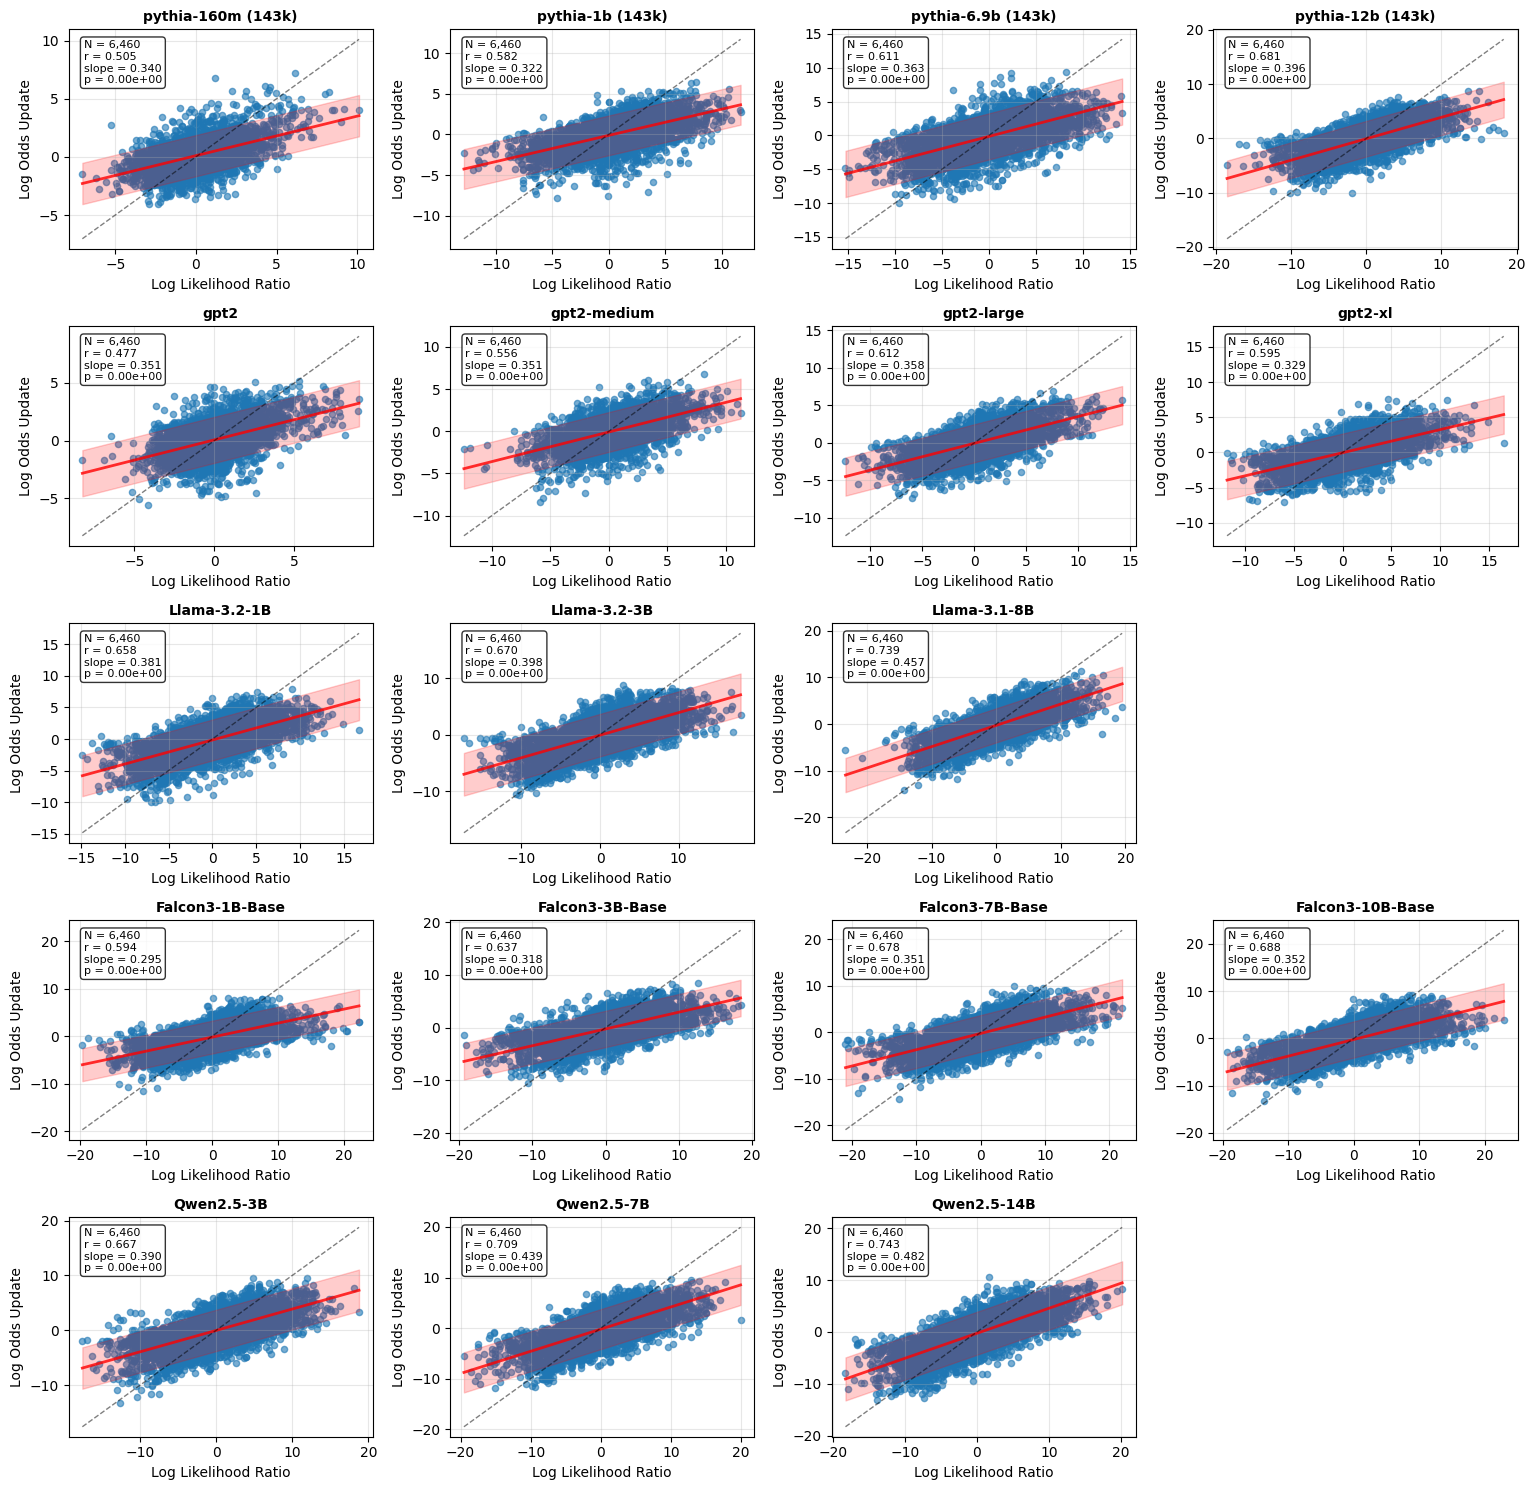


Plot completed! Shows Log Odds Update vs Log Likelihood Ratio
Analyzed 116280 pairwise comparisons across 18 models
The diagonal line represents perfect Bayesian coherence (log odds update = log likelihood ratio)


In [10]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy import stats
from scipy.stats import pearsonr

# Get the metrics data containing log odds updates and log likelihood ratios
pairwise_df = metrics_analyzer.df.copy()

# Organize models by family for subplot structure
model_families_pairwise = {}
for family in pairwise_df["Model Family"].unique():
    family_data = pairwise_df[pairwise_df["Model Family"] == family]
    if family == "Pythia":
        # For Pythia, organize by training steps
        model_families_pairwise[family] = {}
        for step in sorted(family_data["Training Steps"].unique()):
            step_data = family_data[family_data["Training Steps"] == step]
            models = sorted(step_data["Language Model"].unique(), 
                          key=lambda x: step_data[step_data["Language Model"] == x]["#Params (B)"].iloc[0])
            model_families_pairwise[family][step] = models
    else:
        # For other families, just organize by model size
        models = sorted(family_data["Language Model"].unique(),
                       key=lambda x: family_data[family_data["Language Model"] == x]["#Params (B)"].iloc[0])
        model_families_pairwise[family] = {"Final": models}

print("Organized model families for pairwise plotting:")
for family, steps_dict in model_families_pairwise.items():
    print(f"\n{family}:")
    for step, models in steps_dict.items():
        print(f"  {step}: {models}")

# Calculate subplot grid dimensions
pythia_steps = len(model_families_pairwise.get("Pythia", {}))
other_families = sum(1 for f in model_families_pairwise.keys() if f != "Pythia")
n_rows = pythia_steps + other_families

max_models = max(len(models) for family_steps in model_families_pairwise.values() 
                 for models in family_steps.values())
n_cols = max_models

print(f"\nGrid layout: {n_rows} rows x {n_cols} columns")

# Create the subplot grid
fig, axes = plt.subplots(n_rows, n_cols, figsize=(4*n_cols, 3*n_rows))
if n_rows == 1:
    axes = axes.reshape(1, -1)
elif n_cols == 1:
    axes = axes.reshape(-1, 1)

def add_scatter_stats(ax, x, y, model_name, training_step=None):
    """Add statistical annotations to scatter plot."""
    if len(x) < 2:
        ax.text(0.05, 0.95, f"N = {len(x)}\nInsufficient data",
                transform=ax.transAxes, verticalalignment='top',
                bbox=dict(boxstyle="round", facecolor="white", alpha=0.8))
        return

    # Calculate statistics
    n_points = len(x)
    corr, p_value = pearsonr(x, y)
    slope, intercept, r_value, p_value_reg, std_err = stats.linregress(x, y)

    # Plot line of best fit
    x_range = np.linspace(min(x), max(x), 100)
    y_range = slope * x_range + intercept
    ax.plot(x_range, y_range, 'r-', linewidth=2, alpha=0.8, label='Best fit')

    # Add confidence interval
    if len(x) > 2:
        mean_x = np.mean(x)
        n = len(x)
        df_res = n - 2
        mse = np.sum((y - (intercept + slope * x)) ** 2) / df_res
        se = np.sqrt(mse * (1 + 1/n + (x_range - mean_x)**2 / np.sum((x - mean_x)**2)))
        t_val = stats.t.ppf(0.975, df_res)
        ci = t_val * se
        ax.fill_between(x_range, y_range - ci, y_range + ci, color='red', alpha=0.2, label='95% CI')

    # Add diagonal line (perfect coherence)
    ax_min = min(min(x), min(y))
    ax_max = max(max(x), max(y))
    ax.plot([ax_min, ax_max], [ax_min, ax_max], 'k--', alpha=0.5, linewidth=1, label='Perfect coherence')

    # Format statistics text
    title_text = f"{model_name}"
    if training_step is not None and training_step != "unknown":
        title_text += f" ({training_step})"

    stats_text = (f"N = {n_points:,}\n"
                 f"r = {corr:.3f}\n"
                 f"slope = {slope:.3f}\n"
                 f"p = {p_value:.2e}")

    ax.set_title(title_text, fontsize=10, fontweight='bold')
    ax.text(0.05, 0.95, stats_text, transform=ax.transAxes, verticalalignment='top',
            bbox=dict(boxstyle="round", facecolor="white", alpha=0.8), fontsize=8)

current_row = 0

# Plot Pythia models first (multiple rows for training steps)
if "Pythia" in model_families_pairwise:
    pythia_steps_sorted = sorted(model_families_pairwise["Pythia"].keys(), 
                                key=lambda x: ["33k", "66k", "99k", "143k", "unknown"].index(x) if x in ["33k", "66k", "99k", "143k", "unknown"] else 999)
    
    for step in pythia_steps_sorted:
        models = model_families_pairwise["Pythia"][step]
        
        for col_idx, model in enumerate(models):
            ax = axes[current_row, col_idx]
            
            # Get data for this model and training step
            model_data = pairwise_df[
                (pairwise_df["Language Model"] == model) & 
                (pairwise_df["Training Steps"] == step)
            ]
            
            if not model_data.empty and "log_likelihood_ratio" in model_data.columns and "log_odds_update" in model_data.columns:
                # Remove NaN values
                clean_data = model_data.dropna(subset=["log_likelihood_ratio", "log_odds_update"])
                
                if len(clean_data) > 0:
                    x = clean_data["log_likelihood_ratio"].values
                    y = clean_data["log_odds_update"].values
                    
                    # Create scatter plot
                    ax.scatter(x, y, alpha=0.6, s=20)
                    add_scatter_stats(ax, x, y, model, step)
                else:
                    ax.text(0.5, 0.5, f"No clean data\n{model} ({step})", 
                           transform=ax.transAxes, ha='center', va='center')
                    ax.set_title(f"{model} ({step})", fontsize=10)
            else:
                ax.text(0.5, 0.5, f"No data\n{model} ({step})", 
                       transform=ax.transAxes, ha='center', va='center')
                ax.set_title(f"{model} ({step})", fontsize=10)
            
            ax.set_xlabel('Log Likelihood Ratio')
            ax.set_ylabel('Log Odds Update')
            ax.grid(True, alpha=0.3)
        
        # Hide unused subplots in this row
        for empty_idx in range(len(models), n_cols):
            axes[current_row, empty_idx].set_visible(False)
        
        current_row += 1

# Plot other model families
other_families_sorted = [f for f in model_families_pairwise.keys() if f != "Pythia"]
for family in other_families_sorted:
    models = model_families_pairwise[family]["Final"]
    
    for col_idx, model in enumerate(models):
        ax = axes[current_row, col_idx]
        
        # Get data for this model
        model_data = pairwise_df[pairwise_df["Language Model"] == model]
        
        if not model_data.empty and "log_likelihood_ratio" in model_data.columns and "log_odds_update" in model_data.columns:
            # Remove NaN values
            clean_data = model_data.dropna(subset=["log_likelihood_ratio", "log_odds_update"])
            
            if len(clean_data) > 0:
                x = clean_data["log_likelihood_ratio"].values
                y = clean_data["log_odds_update"].values
                
                # Create scatter plot
                ax.scatter(x, y, alpha=0.6, s=20)
                add_scatter_stats(ax, x, y, model)
            else:
                ax.text(0.5, 0.5, f"No clean data\n{model}", 
                       transform=ax.transAxes, ha='center', va='center')
                ax.set_title(f"{model}", fontsize=10)
        else:
            ax.text(0.5, 0.5, f"No data\n{model}", 
                   transform=ax.transAxes, ha='center', va='center')
            ax.set_title(f"{model}", fontsize=10)
        
        ax.set_xlabel('Log Likelihood Ratio')
        ax.set_ylabel('Log Odds Update')
        ax.grid(True, alpha=0.3)
    
    # Hide unused subplots in this row
    for empty_idx in range(len(models), n_cols):
        axes[current_row, empty_idx].set_visible(False)
    
    current_row += 1

plt.tight_layout()
plt.subplots_adjust(left=0.08)

# Save the figure
plt.savefig('results/plots/log_odds_vs_likelihood_ratio.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"\nPlot completed! Shows Log Odds Update vs Log Likelihood Ratio")
print(f"Analyzed {len(pairwise_df)} pairwise comparisons across {len(pairwise_df['Language Model'].unique())} models")
print("The diagonal line represents perfect Bayesian coherence (log odds update = log likelihood ratio)")

In [11]:
from src.metrics import linear_regression

# Use the filtered data for evidence length analysis
correlation_analyzer = metrics_analyzer.calculate_metric(
    metric_func=linear_regression,
    group_by_cols=[
        "Language Model",
        "Training Steps",
    ],
    inherit_identical_values=True,
    col1="log_likelihood_ratio",
    col2="log_odds_update",
)

correlation_analyzer.rename({"r_value": "Bayesian Coherence Coefficient", "slope": "Update Gradient"})  

correlation_analyzer.df

,Language Model,Training Steps,level_2,Update Gradient,intercept,Bayesian Coherence Coefficient,p_value,slope_stderr,intercept_stderr,model_provider,...,model_params,#Params (B),IFEval,BBH,MATH Lvl 5,GPQA,MUSR,MMLU-PRO,Average ⬆️,Model Family
0,Falcon3-10B-Base,unknown,0,0.352452,-0.228069,0.688332,0.0,0.004622,0.024331,hf,...,"{""batch_size"": 16}",10.306,36.477546,41.375462,24.924471,12.751678,14.173958,36.003989,27.617851,Falcon 3
1,Falcon3-1B-Base,unknown,0,0.294802,-0.200419,0.593694,0.0,0.004972,0.021929,hf,...,"{""batch_size"": 64}",1.669,24.280132,11.343173,3.323263,3.914989,9.709115,6.757905,9.888096,Falcon 3
2,Falcon3-3B-Base,unknown,0,0.317853,-0.257080,0.636601,0.0,0.004792,0.021870,hf,...,"{""batch_size"": 32}",3.228,27.649858,21.584784,11.782477,6.263982,6.273698,20.877660,15.738743,Falcon 3
3,Falcon3-7B-Base,unknown,0,0.350928,-0.241135,0.678440,0.0,0.004729,0.025087,hf,...,"{""batch_size"": 16}",7.456,34.159475,31.559919,19.410876,12.863535,18.142708,32.337840,24.745725,Falcon 3
4,Llama-3.1-8B,unknown,0,0.457288,-0.275896,0.739407,0.0,0.005181,0.023264,hf,...,"{""batch_size"": 32}",8.030,12.459829,25.304471,6.570997,8.053691,8.715104,25.421099,14.420865,Llama 3
5,Llama-3.2-1B,unknown,0,0.380992,-0.153280,0.658434,0.0,0.005419,0.020551,hf,...,"{""batch_size"": 64}",1.240,14.777900,4.366030,1.208459,0.000000,2.557813,2.260638,4.195140,Llama 3
6,Llama-3.2-3B,unknown,0,0.398336,-0.095745,0.669634,0.0,0.005498,0.023870,hf,...,"{""batch_size"": 64}",3.213,13.374070,14.232665,1.888218,2.348993,3.814844,16.528147,8.697823,Llama 3
7,Qwen2.5-14B,unknown,0,0.481883,-0.252225,0.743439,0.0,0.005394,0.026322,hf,...,"{""batch_size"": 16}",14.770,36.944640,45.078312,29.003021,17.561521,15.913281,47.205600,31.951063,Qwen 2.5
8,Qwen2.5-3B,unknown,0,0.389953,-0.033646,0.667208,0.0,0.005417,0.023937,hf,...,"{""batch_size"": 64}",3.086,26.895415,24.304242,14.803625,6.375839,11.758333,24.479167,18.102770,Qwen 2.5
9,Qwen2.5-7B,unknown,0,0.438535,-0.210187,0.709002,0.0,0.005428,0.025118,hf,...,"{""batch_size"": 32}",7.616,33.744797,35.813473,25.075529,9.955257,14.136719,37.389184,26.019160,Qwen 2.5


In [12]:
from src.metrics import linear_regression

# Use the filtered data for evidence length analysis
evidence_length_analyzer = metrics_analyzer.calculate_metric(
    metric_func=linear_regression,
    group_by_cols=[
        "likelihood_num_tokens",
        "Language Model",
        "Training Steps",
    ],
    inherit_identical_values=True,  
    col1="log_likelihood_ratio",
    col2="log_odds_update",
)

evidence_length_analyzer.rename({"r_value": "Bayesian Coherence Coefficient", "slope": "Update Gradient"})  

evidence_length_analyzer.df


,likelihood_num_tokens,Language Model,Training Steps,level_3,Update Gradient,intercept,Bayesian Coherence Coefficient,p_value,slope_stderr,intercept_stderr,...,model_params,#Params (B),IFEval,BBH,MATH Lvl 5,GPQA,MUSR,MMLU-PRO,Average ⬆️,Model Family
0,3,Falcon3-10B-Base,unknown,0,0.072112,-0.432145,0.182974,1.617113e-01,0.050875,0.202984,...,"{""batch_size"": 16}",10.306,36.477546,41.375462,24.924471,12.751678,14.173958,36.003989,27.617851,Falcon 3
1,3,Falcon3-1B-Base,unknown,0,0.426351,-0.239126,0.450504,3.039187e-04,0.110942,0.187759,...,"{""batch_size"": 64}",1.669,24.280132,11.343173,3.323263,3.914989,9.709115,6.757905,9.888096,Falcon 3
2,3,Falcon3-3B-Base,unknown,0,0.153651,-0.572112,0.189664,1.466576e-01,0.104444,0.232133,...,"{""batch_size"": 32}",3.228,27.649858,21.584784,11.782477,6.263982,6.273698,20.877660,15.738743,Falcon 3
3,3,Falcon3-7B-Base,unknown,0,0.167769,-0.028784,0.301463,1.924535e-02,0.069675,0.214448,...,"{""batch_size"": 16}",7.456,34.159475,31.559919,19.410876,12.863535,18.142708,32.337840,24.745725,Falcon 3
4,3,Llama-3.1-8B,unknown,0,0.474575,-0.301108,0.767879,8.128455e-13,0.051985,0.128457,...,"{""batch_size"": 32}",8.030,12.459829,25.304471,6.570997,8.053691,8.715104,25.421099,14.420865,Llama 3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
290,23,Falcon3-3B-Base,unknown,0,0.073000,-3.148102,0.155772,4.110898e-01,0.087482,0.430265,...,"{""batch_size"": 32}",3.228,27.649858,21.584784,11.782477,6.263982,6.273698,20.877660,15.738743,Falcon 3
291,23,Falcon3-7B-Base,unknown,0,0.339252,-0.029743,0.890520,4.405356e-11,0.032754,0.243359,...,"{""batch_size"": 16}",7.456,34.159475,31.559919,19.410876,12.863535,18.142708,32.337840,24.745725,Falcon 3
292,23,Qwen2.5-14B,unknown,0,0.682909,-0.583358,0.819481,3.052884e-08,0.090257,0.605048,...,"{""batch_size"": 16}",14.770,36.944640,45.078312,29.003021,17.561521,15.913281,47.205600,31.951063,Qwen 2.5
293,23,Qwen2.5-3B,unknown,0,-0.124306,-3.466479,-0.365003,4.733596e-02,0.059920,0.522426,...,"{""batch_size"": 64}",3.086,26.895415,24.304242,14.803625,6.375839,11.758333,24.479167,18.102770,Qwen 2.5


## Plot: Bayesian Coherence Coefficient vs Evidence Length

Creating a subplot grid with horizontally concatenated model names and vertically concatenated model families (with training steps for Pythia models).



Grid layout: 5 rows x 4 columns


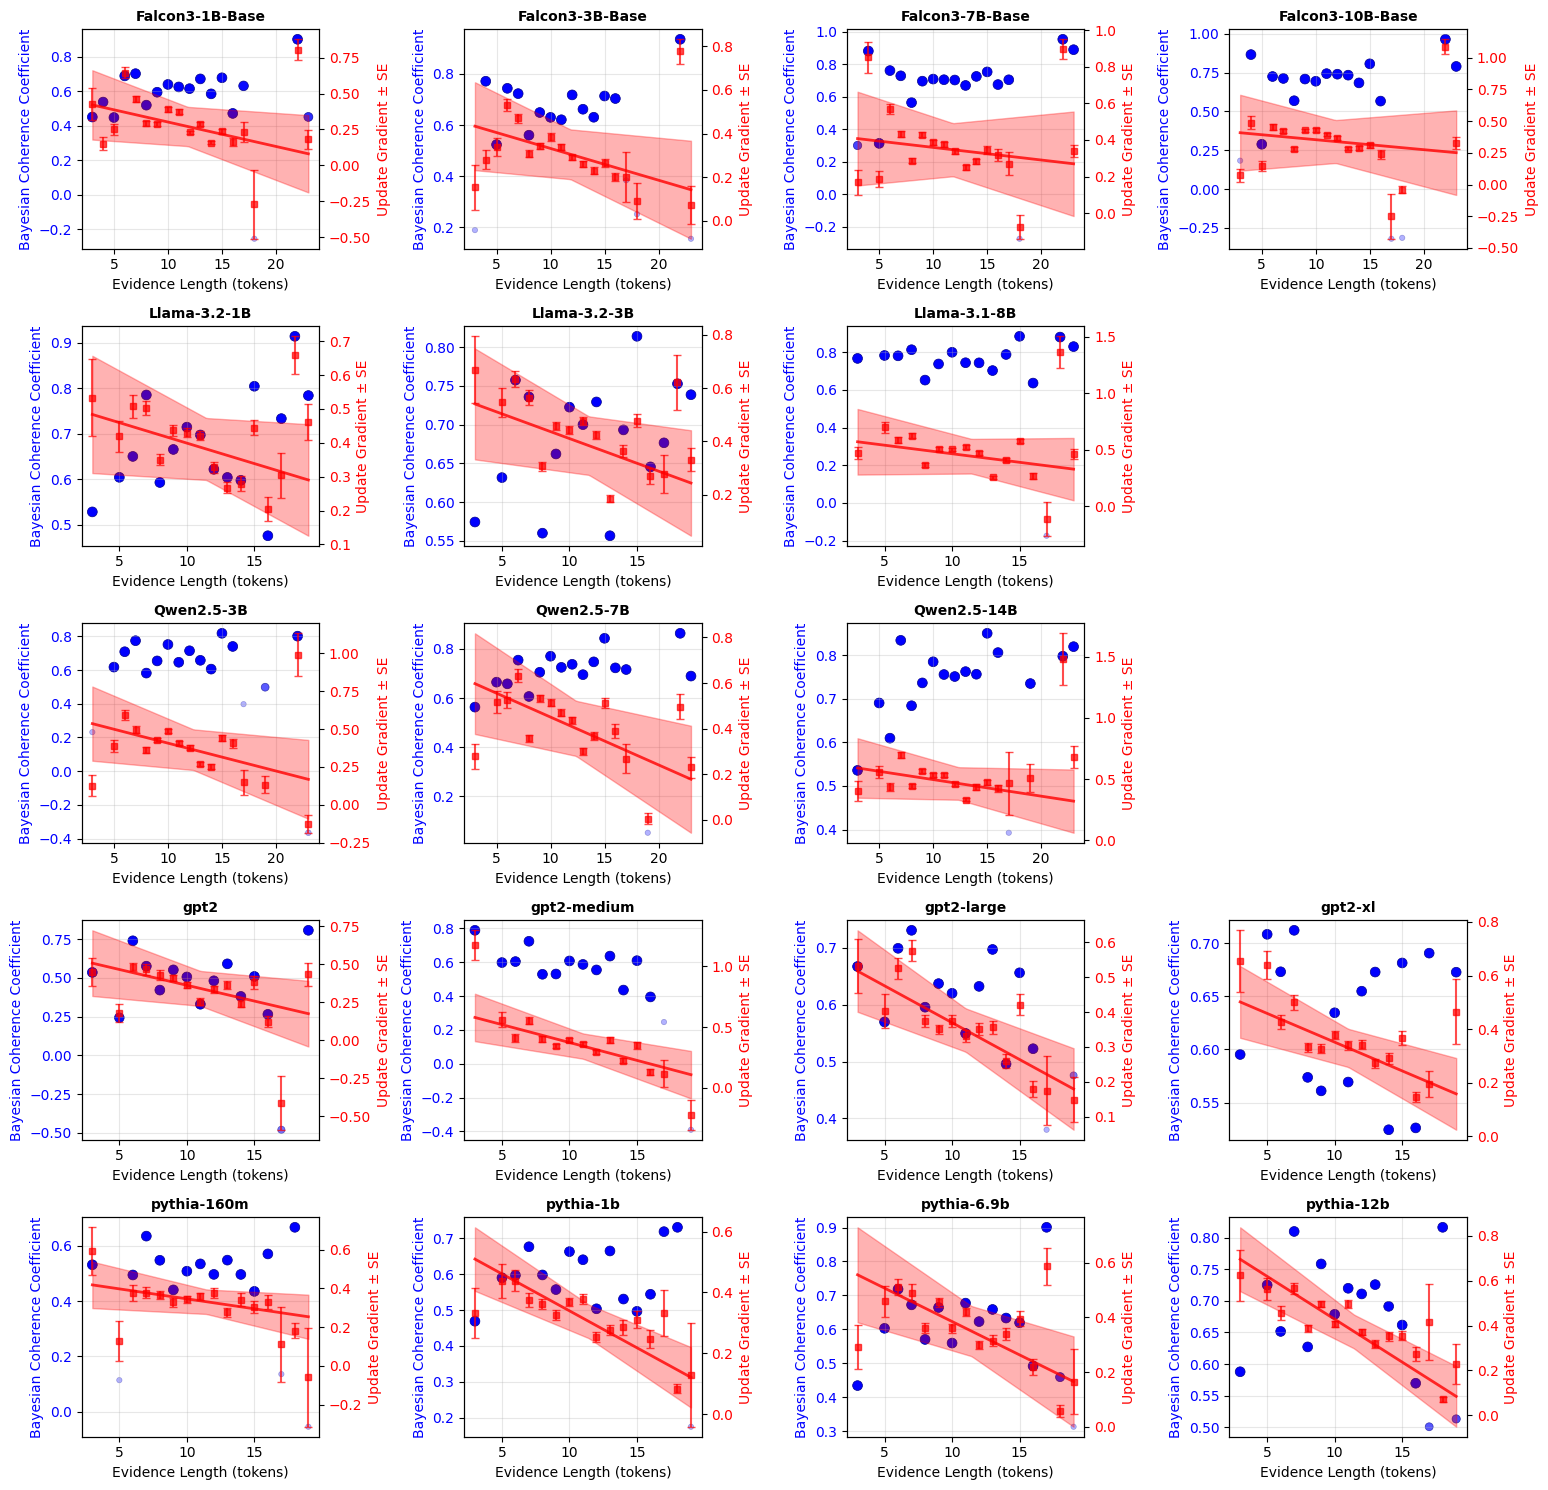

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy import stats

# Get the evidence length data
evidence_df = evidence_length_analyzer.df.copy()

# Organize models by family for subplot structure
model_families_plot = {}
for family in evidence_df["Model Family"].unique():
    family_data = evidence_df[evidence_df["Model Family"] == family]
    if family == "Pythia":
        # For Pythia, only use the final checkpoint (143k)
        final_step_data = family_data[family_data["Training Steps"] == "143k"]
        if not final_step_data.empty:
            models = sorted(final_step_data["Language Model"].unique(), 
                          key=lambda x: final_step_data[final_step_data["Language Model"] == x]["#Params (B)"].iloc[0])
            model_families_plot[family] = {"Final": models}
    else:
        # For other families, organize by model size
        models = sorted(family_data["Language Model"].unique(),
                       key=lambda x: family_data[family_data["Language Model"] == x]["#Params (B)"].iloc[0])
        model_families_plot[family] = {"Final": models}

# Calculate subplot grid dimensions (now all families are treated the same way)
n_rows = len(model_families_plot.keys())  # One row per family
max_models = max(len(models) for family_steps in model_families_plot.values() 
                 for models in family_steps.values())
n_cols = max_models

print(f"\nGrid layout: {n_rows} rows x {n_cols} columns")

# Create the subplot grid
fig, axes = plt.subplots(n_rows, n_cols, figsize=(4*n_cols, 3*n_rows))
if n_rows == 1:
    axes = axes.reshape(1, -1)
elif n_cols == 1:
    axes = axes.reshape(-1, 1)

def add_weighted_trend_with_uncertainty(ax, x, y, yerr, color, alpha=0.3):
    """Add a weighted trend line with uncertainty band based on individual point uncertainties."""
    if len(x) < 2:
        return
    
    # Weight points inversely by their uncertainty (lower uncertainty = higher weight)
    weights = 1.0 / (yerr + 1e-8)  # Add small epsilon to avoid division by zero
    
    # Fit weighted linear regression
    try:
        # Use weighted polyfit
        z = np.polyfit(x, y, 1, w=weights)
        trend_func = np.poly1d(z)
        
        # Create smooth x range for trend line
        x_smooth = np.linspace(x.min(), x.max(), 100)
        y_trend = trend_func(x_smooth)
        
        # Calculate prediction interval based on residuals and weights
        y_pred = trend_func(x)
        residuals = y - y_pred
        weighted_mse = np.sum(weights * residuals**2) / np.sum(weights)
        
        # Estimate uncertainty band (conservative approach)
        uncertainty_band = np.sqrt(weighted_mse) * (1 + 0.5 * np.abs(x_smooth - np.mean(x)) / np.std(x))
        
        # Plot trend line and uncertainty band
        ax.plot(x_smooth, y_trend, color=color, linewidth=2, alpha=0.8, label='Weighted trend')
        ax.fill_between(x_smooth, y_trend - uncertainty_band, y_trend + uncertainty_band, 
                       color=color, alpha=alpha, label='Uncertainty band')
        
        return z[0]  # Return slope
    except:
        return None

current_row = 0

# Plot all model families (now all treated the same way)
for family in model_families_plot.keys():
    models = model_families_plot[family]["Final"]
    
    for col_idx, model in enumerate(models):
        ax1 = axes[current_row, col_idx]
        ax2 = ax1.twinx()  # Create secondary y-axis
        
        # Get data for this model
        model_data = evidence_df[evidence_df["Language Model"] == model]
        
        if not model_data.empty:
            # Plot BCC on primary y-axis with point styling based on p-value significance
            p_values = model_data["p_value"]
            point_sizes = 15 + 35 * (1 - np.clip(p_values / 0.05, 0, 1))  # 15-50 size range
            point_alphas = 0.3 + 0.7 * (1 - np.clip(p_values / 0.05, 0, 1))  # 0.3-1.0 alpha range
            
            # Create a scatter plot with varying size and alpha based on significance
            ax1.scatter(model_data["likelihood_num_tokens"], 
                      model_data["Bayesian Coherence Coefficient"],
                      s=point_sizes, alpha=point_alphas, color='blue',
                      label='BCC (size/alpha=significance)', edgecolors='darkblue', linewidth=0.5)
            
            # Plot Update Gradient with error bars on secondary y-axis
            ax2.errorbar(model_data["likelihood_num_tokens"], 
                       model_data["Update Gradient"],
                       yerr=model_data["slope_stderr"],
                       fmt='s', color='red', alpha=0.7, markersize=5, 
                       capsize=3, capthick=1, label='Gradient ± SE')
            
            # Add trend lines if enough points
            if len(model_data) > 1:
                # # BCC trend line weighted by statistical significance (lower p-value = higher weight)
                # bcc_weights = 1.0 / (model_data["p_value"] + 1e-99)  # Avoid division by zero
                # z1 = np.polyfit(model_data["likelihood_num_tokens"], 
                #               model_data["Bayesian Coherence Coefficient"], 1, w=bcc_weights)
                # p1 = np.poly1d(z1)
                # x_trend = np.linspace(model_data["likelihood_num_tokens"].min(), 
                #                     model_data["likelihood_num_tokens"].max(), 100)
                # ax1.plot(x_trend, p1(x_trend), "b--", alpha=0.8, linewidth=1,
                #        label='Significance-weighted trend')
                
                # Weighted trend for Update Gradient (incorporating uncertainty)
                slope = add_weighted_trend_with_uncertainty(
                    ax2, 
                    model_data["likelihood_num_tokens"].values, 
                    model_data["Update Gradient"].values,
                    model_data["slope_stderr"].values,
                    'red'
                )
            
            # Calculate correlations
            corr_bcc = model_data["likelihood_num_tokens"].corr(model_data["Bayesian Coherence Coefficient"])
            corr_grad = model_data["likelihood_num_tokens"].corr(model_data["Update Gradient"])
            
            # Calculate mean uncertainty for this model
            mean_stderr = model_data["slope_stderr"].mean()
            mean_pvalue = model_data["p_value"].mean()
            sig_fraction = (model_data["p_value"] < 0.05).mean()
            
            ax1.set_title(f"{model}", fontsize=10, fontweight='bold')
            # ax1.text(0.05, 0.95, f"BCC r = {corr_bcc:.3f}\nGrad r = {corr_grad:.3f}\nMean SE = {mean_stderr:.3f}\nMean p = {mean_pvalue:.3f}\nSig% = {sig_fraction:.0%}\nN = {len(model_data)}", 
            #        transform=ax1.transAxes, verticalalignment='top',
            #        bbox=dict(boxstyle="round", facecolor="white", alpha=0.8), fontsize=7)
        else:
            ax1.text(0.5, 0.5, f"No data\n{model}", 
                   transform=ax1.transAxes, ha='center', va='center')
            ax1.set_title(f"{model}", fontsize=10)
        
        ax1.set_xlabel('Evidence Length (tokens)')
        ax1.set_ylabel('Bayesian Coherence Coefficient', color='blue')
        ax2.set_ylabel('Update Gradient ± SE', color='red')
        ax1.tick_params(axis='y', labelcolor='blue')
        ax2.tick_params(axis='y', labelcolor='red')
        ax1.grid(True, alpha=0.3)
    
    # Hide unused subplots in this row
    for empty_idx in range(len(models), n_cols):
        axes[current_row, empty_idx].set_visible(False)
    
    current_row += 1

plt.tight_layout()
plt.subplots_adjust(left=0.08)

# Save the figure
plt.savefig('results/plots/bcc_vs_evidence_length.png', dpi=300, bbox_inches='tight')
plt.show()


In [14]:
# Analysis of Coherence vs Average Evidence Log Likelihood
# 
# The pairwise_ratios function has been updated to also calculate pairwise averages
# automatically, so we already have log_likelihood_avg in metrics_analyzer.df
# We just need to rename it and proceed with the analysis.

print("Setting up avg_evidence_log_likelihood analysis...")
print(f"metrics_analyzer currently has {len(metrics_analyzer.df)} rows")
print("Columns with 'avg' or 'likelihood':", [col for col in metrics_analyzer.df.columns if 'avg' in col or 'likelihood' in col])

Setting up avg_evidence_log_likelihood analysis...
metrics_analyzer currently has 116280 rows
Columns with 'avg' or 'likelihood': ['log_likelihood_ratio', 'log_prior_avg', 'log_likelihood_avg', 'log_posterior_avg', 'likelihood_num_tokens']


In [15]:
# The pairwise_ratios function now also calculates averages automatically!
# We can use the log_likelihood_avg column that was created by pairwise_ratios

# Rename the column for clarity
metrics_analyzer.rename({"log_likelihood_avg": "avg_evidence_log_likelihood"})

print("Using pairwise average evidence log likelihood from metrics_analyzer:")
print(f"Number of pairwise comparisons: {len(metrics_analyzer.df)}")
print(f"Available columns:", [col for col in metrics_analyzer.df.columns if 'avg' in col or 'likelihood' in col])

if 'avg_evidence_log_likelihood' in metrics_analyzer.df.columns:
    print(f"avg_evidence_log_likelihood range: {metrics_analyzer.df['avg_evidence_log_likelihood'].min():.3f} to {metrics_analyzer.df['avg_evidence_log_likelihood'].max():.3f}")
    
    # Filter to only include avg_evidence_log_likelihood values with sufficient data points
    min_rows_per_avg_logprob = 100  # Same threshold as used for likelihood_num_tokens
    
    # Count occurrences and bin the avg_evidence_log_likelihood values since they're continuous
    # We'll bin into ranges for analysis
    avg_logprob_bins = pd.qcut(metrics_analyzer.df['avg_evidence_log_likelihood'].dropna(), 
                              q=10, duplicates='drop')  # Create 10 quantile bins
    metrics_analyzer.add_column(
        column_name="avg_evidence_log_likelihood_bin",
        column_spec=lambda df: pd.qcut(df['avg_evidence_log_likelihood'], q=10, duplicates='drop')
    )
    
    # Count occurrences of each bin
    bin_counts = metrics_analyzer.df['avg_evidence_log_likelihood_bin'].value_counts()
    print("Average evidence log likelihood bin distribution:")
    print(bin_counts.sort_index())
    print(f"Total: {bin_counts.sum()}")
    
    # Get bins that have at least min_rows_per_avg_logprob occurrences
    valid_bins = bin_counts[bin_counts >= min_rows_per_avg_logprob].index
    print(f"Filtering to bins with at least {min_rows_per_avg_logprob} rows:")
    print(f"Valid bins: {len(valid_bins)} out of {len(bin_counts)}")
    
    # Filter the dataframe
    from copy import copy
    filtered_avg_metrics_analyzer = copy(metrics_analyzer)
    filtered_avg_metrics_analyzer.filter({"avg_evidence_log_likelihood_bin": valid_bins.tolist()})
    
    print(f"Number of rows in filtered_avg_metrics_analyzer: {len(filtered_avg_metrics_analyzer.df)}")
    
else:
    print("avg_evidence_log_likelihood column not found")
    print("All columns:", metrics_analyzer.df.columns.tolist())

Using pairwise average evidence log likelihood from metrics_analyzer:
Number of pairwise comparisons: 116280
Available columns: ['log_likelihood_ratio', 'log_prior_avg', 'avg_evidence_log_likelihood', 'log_posterior_avg', 'likelihood_num_tokens']
avg_evidence_log_likelihood range: -87.788 to -9.054
Average evidence log likelihood bin distribution:
avg_evidence_log_likelihood_bin
(-87.789, -52.885]    11628
(-52.885, -47.4]      11628
(-47.4, -43.747]      11628
(-43.747, -40.51]     11628
(-40.51, -37.377]     11628
(-37.377, -34.51]     11628
(-34.51, -31.531]     11628
(-31.531, -28.321]    11628
(-28.321, -24.36]     11628
(-24.36, -9.054]      11628
Name: count, dtype: int64
Total: 116280
Filtering to bins with at least 100 rows:
Valid bins: 10 out of 10
Number of rows in filtered_avg_metrics_analyzer: 116280


In [16]:
from src.metrics import linear_regression

# Use the filtered data for average evidence log likelihood analysis
avg_logprob_length_analyzer = filtered_avg_metrics_analyzer.calculate_metric(
    metric_func=linear_regression,
    group_by_cols=[
        "avg_evidence_log_likelihood_bin",
        "Language Model",
        "Training Steps",
    ],
    inherit_identical_values=True,  
    col1="log_likelihood_ratio",
    col2="log_odds_update",
)

avg_logprob_length_analyzer.rename({"r_value": "Bayesian Coherence Coefficient", "slope": "Update Gradient"})  

print("Average evidence log likelihood analysis results:")
print(f"Number of bin-model combinations analyzed: {len(avg_logprob_length_analyzer.df)}")
if len(avg_logprob_length_analyzer.df) > 0:
    print(avg_logprob_length_analyzer.df.head())
else:
    print("No results generated")

Average evidence log likelihood analysis results:
Number of bin-model combinations analyzed: 180
  avg_evidence_log_likelihood_bin    Language Model Training Steps  level_3  \
0              (-87.789, -52.885]  Falcon3-10B-Base        unknown        0   
1              (-87.789, -52.885]   Falcon3-1B-Base        unknown        0   
2              (-87.789, -52.885]   Falcon3-3B-Base        unknown        0   
3              (-87.789, -52.885]   Falcon3-7B-Base        unknown        0   
4              (-87.789, -52.885]      Llama-3.1-8B        unknown        0   

   Update Gradient  intercept  Bayesian Coherence Coefficient       p_value  \
0         0.227549   0.018696                        0.553615  6.120896e-31   
1         0.125999   0.035344                        0.494518  1.534517e-30   
2         0.183965  -0.093408                        0.534507  7.845478e-35   
3         0.248617  -0.077353                        0.598105  9.098206e-49   
4         0.264100  -0.218407    

In [17]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy import stats

# Get the average evidence log likelihood analysis data
avg_logprob_df = avg_logprob_length_analyzer.df.copy()

# Convert interval bins to numeric midpoints for plotting
def interval_to_midpoint(interval):
    """Convert pandas Interval to its midpoint for plotting."""
    if pd.isna(interval):
        return np.nan
    return (interval.left + interval.right) / 2

avg_logprob_df['avg_evidence_log_likelihood_midpoint'] = avg_logprob_df['avg_evidence_log_likelihood_bin'].apply(interval_to_midpoint)

# Organize models by family for subplot structure (same as before)
model_families_plot = {}
for family in avg_logprob_df["Model Family"].unique():
    family_data = avg_logprob_df[avg_logprob_df["Model Family"] == family]
    if family == "Pythia":
        # For Pythia, only use the final checkpoint (143k)
        final_step_data = family_data[family_data["Training Steps"] == "143k"]
        if not final_step_data.empty:
            models = sorted(final_step_data["Language Model"].unique(), 
                          key=lambda x: final_step_data[final_step_data["Language Model"] == x]["#Params (B)"].iloc[0])
            model_families_plot[family] = {"Final": models}
    else:
        # For other families, organize by model size
        models = sorted(family_data["Language Model"].unique(),
                       key=lambda x: family_data[family_data["Language Model"] == x]["#Params (B)"].iloc[0])
        model_families_plot[family] = {"Final": models}

print("Organized model families for avg evidence log likelihood plotting:")
for family, steps_dict in model_families_plot.items():
    print(f"\n{family}:")
    for step, models in steps_dict.items():
        print(f"  {step}: {models}")

# Calculate subplot grid dimensions
n_rows = len(model_families_plot.keys())
max_models = max(len(models) for family_steps in model_families_plot.values() 
                 for models in family_steps.values())
n_cols = max_models

print(f"\nGrid layout: {n_rows} rows x {n_cols} columns")


Organized model families for avg evidence log likelihood plotting:

Falcon 3:
  Final: ['Falcon3-1B-Base', 'Falcon3-3B-Base', 'Falcon3-7B-Base', 'Falcon3-10B-Base']

Llama 3:
  Final: ['Llama-3.2-1B', 'Llama-3.2-3B', 'Llama-3.1-8B']

Qwen 2.5:
  Final: ['Qwen2.5-3B', 'Qwen2.5-7B', 'Qwen2.5-14B']

GPT 2:
  Final: ['gpt2', 'gpt2-medium', 'gpt2-large', 'gpt2-xl']

Pythia:
  Final: ['pythia-160m', 'pythia-1b', 'pythia-6.9b', 'pythia-12b']

Grid layout: 5 rows x 4 columns


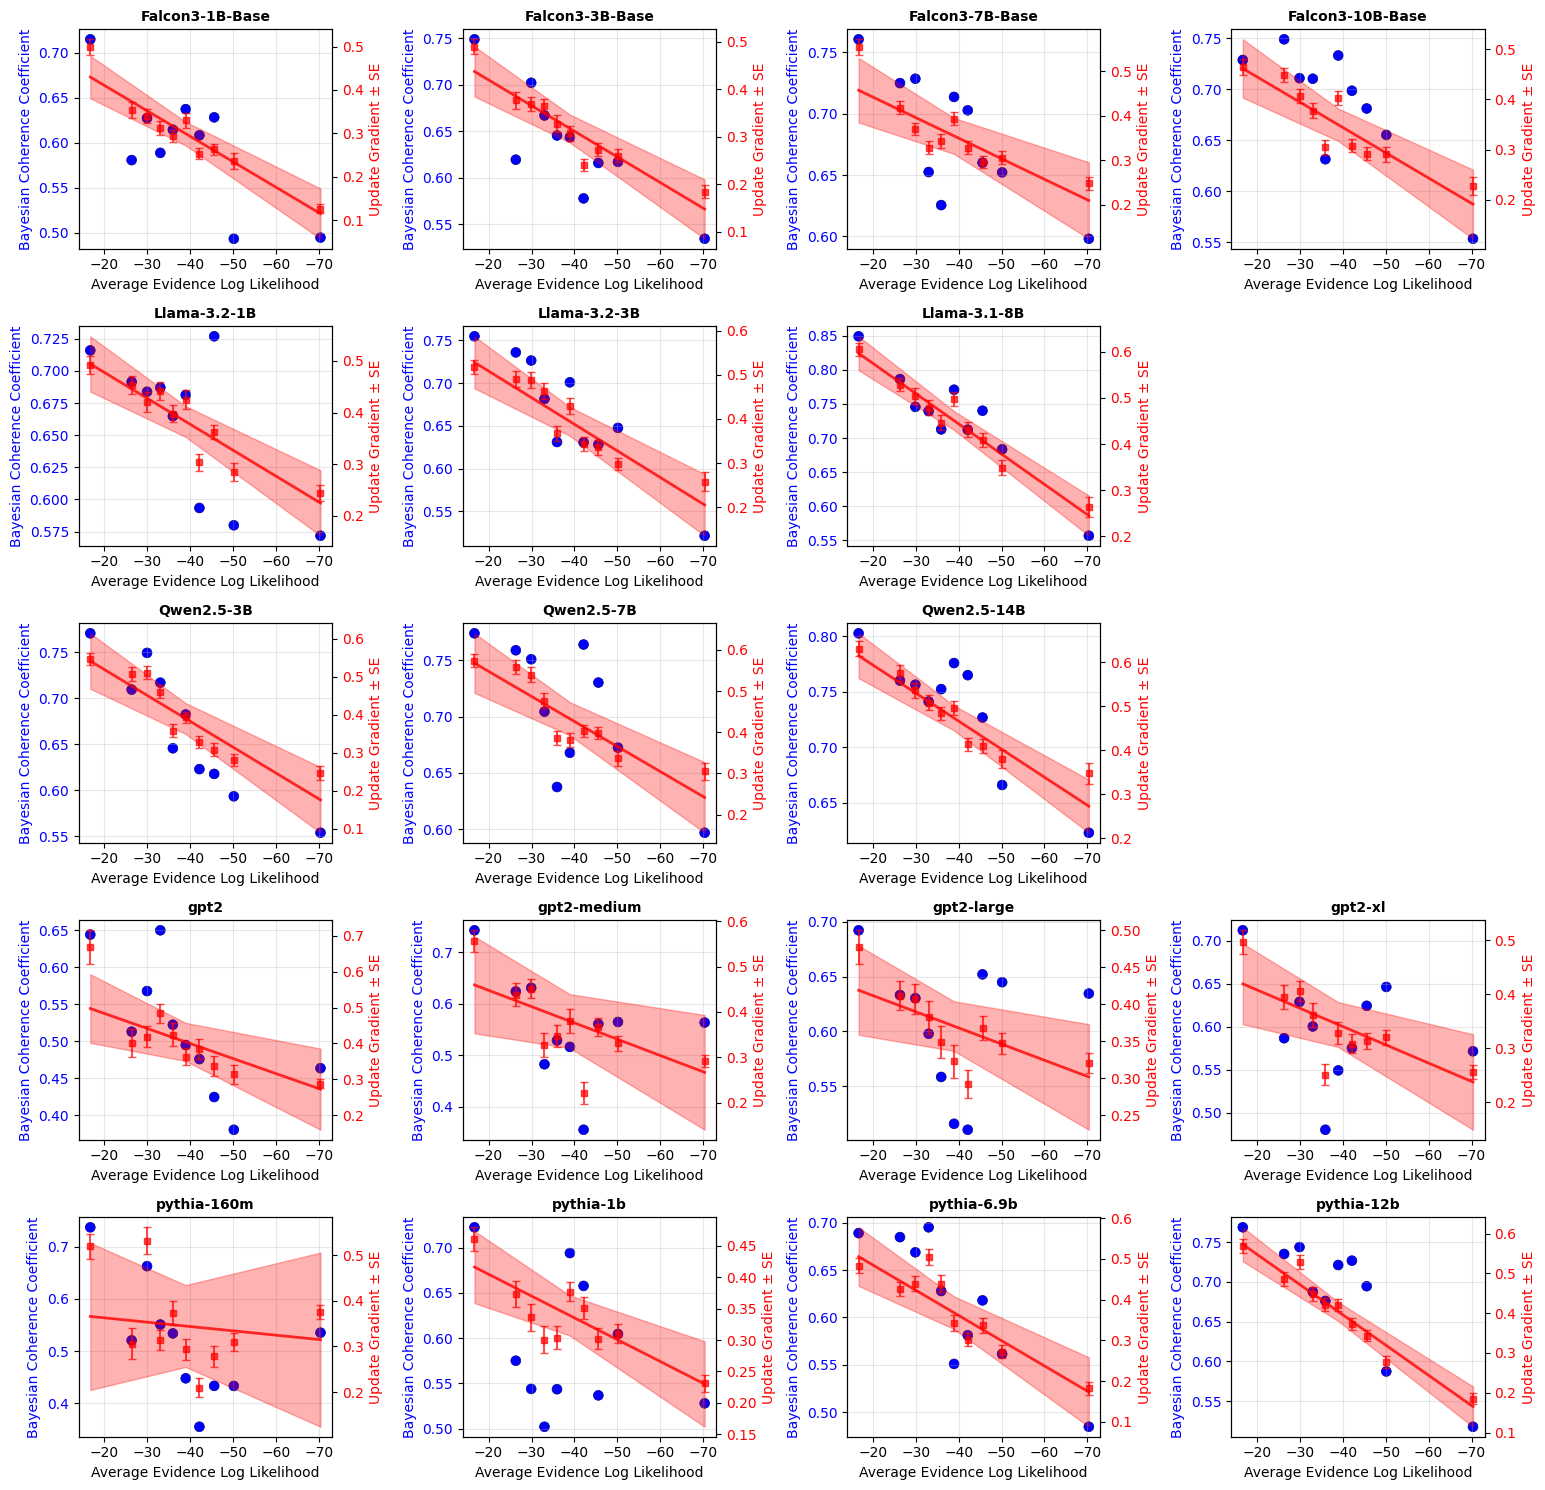

In [18]:
# Create the subplot grid
fig, axes = plt.subplots(n_rows, n_cols, figsize=(4*n_cols, 3*n_rows))
if n_rows == 1:
    axes = axes.reshape(1, -1)
elif n_cols == 1:
    axes = axes.reshape(-1, 1)

def add_weighted_trend_with_uncertainty(ax, x, y, yerr, color, alpha=0.3):
    """Add a weighted trend line with uncertainty band based on individual point uncertainties."""
    if len(x) < 2:
        return
    
    # Weight points inversely by their uncertainty (lower uncertainty = higher weight)
    weights = 1.0 / (yerr + 1e-8)  # Add small epsilon to avoid division by zero
    
    # Fit weighted linear regression
    try:
        # Use weighted polyfit
        z = np.polyfit(x, y, 1, w=weights)
        trend_func = np.poly1d(z)
        
        # Create smooth x range for trend line
        x_smooth = np.linspace(x.min(), x.max(), 100)
        y_trend = trend_func(x_smooth)
        
        # Calculate prediction interval based on residuals and weights
        y_pred = trend_func(x)
        residuals = y - y_pred
        weighted_mse = np.sum(weights * residuals**2) / np.sum(weights)
        
        # Estimate uncertainty band (conservative approach)
        uncertainty_band = np.sqrt(weighted_mse) * (1 + 0.5 * np.abs(x_smooth - np.mean(x)) / np.std(x))
        
        # Plot trend line and uncertainty band
        ax.plot(x_smooth, y_trend, color=color, linewidth=2, alpha=0.8, label='Weighted trend')
        ax.fill_between(x_smooth, y_trend - uncertainty_band, y_trend + uncertainty_band, 
                       color=color, alpha=alpha, label='Uncertainty band')
        
        return z[0]  # Return slope
    except:
        return None

current_row = 0

# Plot all model families (same structure as evidence length analysis)
for family in model_families_plot.keys():
    models = model_families_plot[family]["Final"]
    
    for col_idx, model in enumerate(models):
        ax1 = axes[current_row, col_idx]
        ax2 = ax1.twinx()  # Create secondary y-axis
        
        # Get data for this model
        model_data = avg_logprob_df[avg_logprob_df["Language Model"] == model]
        
        if not model_data.empty:
            # Plot BCC on primary y-axis with point styling based on p-value significance
            p_values = model_data["p_value"]
            point_sizes = 15 + 35 * (1 - np.clip(p_values / 0.05, 0, 1))  # 15-50 size range
            point_alphas = 0.3 + 0.7 * (1 - np.clip(p_values / 0.05, 0, 1))  # 0.3-1.0 alpha range
            
            # Create a scatter plot with varying size and alpha based on significance
            ax1.scatter(model_data["avg_evidence_log_likelihood_midpoint"], 
                      model_data["Bayesian Coherence Coefficient"],
                      s=point_sizes, alpha=point_alphas, color='blue',
                      label='BCC (size/alpha=significance)', edgecolors='darkblue', linewidth=0.5)
            
            # Plot Update Gradient with error bars on secondary y-axis
            ax2.errorbar(model_data["avg_evidence_log_likelihood_midpoint"], 
                       model_data["Update Gradient"],
                       yerr=model_data["slope_stderr"],
                       fmt='s', color='red', alpha=0.7, markersize=5, 
                       capsize=3, capthick=1, label='Gradient ± SE')
            
            # Add trend lines if enough points
            if len(model_data) > 1:
                # # BCC trend line weighted by statistical significance (lower p-value = higher weight)
                # bcc_weights = 1.0 / (model_data["p_value"] + 1e-99)  # Avoid division by zero
                # z1 = np.polyfit(model_data["avg_evidence_log_likelihood_midpoint"], 
                #               model_data["Bayesian Coherence Coefficient"], 1, w=bcc_weights)
                # p1 = np.poly1d(z1)
                # x_trend = np.linspace(model_data["avg_evidence_log_likelihood_midpoint"].min(), 
                #                     model_data["avg_evidence_log_likelihood_midpoint"].max(), 100)
                # ax1.plot(x_trend, p1(x_trend), "b--", alpha=0.8, linewidth=1,
                #        label='Significance-weighted trend')
                
                # Weighted trend for Update Gradient (incorporating uncertainty)
                slope = add_weighted_trend_with_uncertainty(
                    ax2, 
                    model_data["avg_evidence_log_likelihood_midpoint"].values, 
                    model_data["Update Gradient"].values,
                    model_data["slope_stderr"].values,
                    'red'
                )
            
            # Calculate correlations
            corr_bcc = model_data["avg_evidence_log_likelihood_midpoint"].corr(model_data["Bayesian Coherence Coefficient"])
            corr_grad = model_data["avg_evidence_log_likelihood_midpoint"].corr(model_data["Update Gradient"])
            
            ax1.set_title(f"{model}", fontsize=10, fontweight='bold')
        else:
            ax1.text(0.5, 0.5, f"No data\n{model}", 
                   transform=ax1.transAxes, ha='center', va='center')
            ax1.set_title(f"{model}", fontsize=10)
        
        ax1.set_xlabel('Average Evidence Log Likelihood')
        ax1.set_ylabel('Bayesian Coherence Coefficient', color='blue')
        ax2.set_ylabel('Update Gradient ± SE', color='red')
        ax1.tick_params(axis='y', labelcolor='blue')
        ax2.tick_params(axis='y', labelcolor='red')
        ax1.grid(True, alpha=0.3)
        
        # Invert x-axis so higher (less negative) likelihood values are on the left
        ax1.invert_xaxis()
    
    # Hide unused subplots in this row
    for empty_idx in range(len(models), n_cols):
        axes[current_row, empty_idx].set_visible(False)
    
    current_row += 1

plt.tight_layout()
plt.subplots_adjust(left=0.08)

# Save the figure
plt.savefig('results/plots/bcc_vs_avg_evidence_log_likelihood.png', dpi=300, bbox_inches='tight')
plt.show()


In [19]:
# Calculate average class log probability from prior and posterior averages
# This represents the overall magnitude of class probabilities

# Add the avg_class_log_probability column
metrics_analyzer.add_column(
    column_name="avg_class_log_probability",
    column_spec=lambda df: (df['log_prior_avg'] + df['log_posterior_avg']) / 2
)

print("Generated average class log probabilities:")
print(f"Number of pairwise comparisons: {len(metrics_analyzer.df)}")
print(f"Available columns with 'avg':", [col for col in metrics_analyzer.df.columns if 'avg' in col])

if 'avg_class_log_probability' in metrics_analyzer.df.columns:
    print(f"avg_class_log_probability range: {metrics_analyzer.df['avg_class_log_probability'].min():.3f} to {metrics_analyzer.df['avg_class_log_probability'].max():.3f}")
    
    # Filter to only include avg_class_log_probability values with sufficient data points
    min_rows_per_avg_class = 100  # Same threshold as used for other analyses
    
    # Count occurrences and bin the avg_class_log_probability values since they're continuous
    # We'll bin into ranges for analysis
    avg_class_bins = pd.qcut(metrics_analyzer.df['avg_class_log_probability'].dropna(), 
                            q=10, duplicates='drop')  # Create 10 quantile bins
    metrics_analyzer.add_column(
        column_name="avg_class_log_probability_bin",
        column_spec=lambda df: pd.qcut(df['avg_class_log_probability'], q=10, duplicates='drop')
    )
    
    # Count occurrences of each bin
    bin_counts = metrics_analyzer.df['avg_class_log_probability_bin'].value_counts()
    print("Average class log probability bin distribution:")
    print(bin_counts.sort_index())
    print(f"Total: {bin_counts.sum()}")
    
    # Get bins that have at least min_rows_per_avg_class occurrences
    valid_bins = bin_counts[bin_counts >= min_rows_per_avg_class].index
    print(f"\nFiltering to bins with at least {min_rows_per_avg_class} rows:")
    print(f"Valid bins: {len(valid_bins)} out of {len(bin_counts)}")
    
    # Filter the dataframe
    from copy import copy
    filtered_avg_class_analyzer = copy(metrics_analyzer)
    filtered_avg_class_analyzer.filter({"avg_class_log_probability_bin": valid_bins.tolist()})
    
    print(f"Number of rows in filtered_avg_class_analyzer: {len(filtered_avg_class_analyzer.df)}")
    
else:
    print("avg_class_log_probability column not found")
    print("All columns:", metrics_analyzer.df.columns.tolist())


Generated average class log probabilities:
Number of pairwise comparisons: 116280
Available columns with 'avg': ['log_prior_avg', 'avg_evidence_log_likelihood', 'log_posterior_avg', 'avg_evidence_log_likelihood_bin', 'avg_class_log_probability']
avg_class_log_probability range: -20.563 to -2.380
Average class log probability bin distribution:
avg_class_log_probability_bin
(-20.564, -13.049]    11628
(-13.049, -11.533]    11628
(-11.533, -10.345]    11628
(-10.345, -9.352]     11628
(-9.352, -8.455]      11628
(-8.455, -7.673]      11628
(-7.673, -6.946]      11628
(-6.946, -6.165]      11628
(-6.165, -5.044]      11628
(-5.044, -2.38]       11628
Name: count, dtype: int64
Total: 116280

Filtering to bins with at least 100 rows:
Valid bins: 10 out of 10
Number of rows in filtered_avg_class_analyzer: 116280


In [20]:
from src.metrics import linear_regression

# Use the filtered data for average class log probability analysis
avg_class_length_analyzer = filtered_avg_class_analyzer.calculate_metric(
    metric_func=linear_regression,
    group_by_cols=[
        "avg_class_log_probability_bin",
        "Language Model",
        "Training Steps",
    ],
    inherit_identical_values=True,  
    col1="log_likelihood_ratio",
    col2="log_odds_update",
)

avg_class_length_analyzer.rename({"r_value": "Bayesian Coherence Coefficient", "slope": "Update Gradient"})  

print("Average class log probability analysis results:")
print(f"Number of bin-model combinations analyzed: {len(avg_class_length_analyzer.df)}")
if len(avg_class_length_analyzer.df) > 0:
    print(avg_class_length_analyzer.df.head())
else:
    print("No results generated")


Average class log probability analysis results:
Number of bin-model combinations analyzed: 179
  avg_class_log_probability_bin    Language Model Training Steps  level_3  \
0            (-20.564, -13.049]  Falcon3-10B-Base        unknown        0   
1            (-20.564, -13.049]   Falcon3-1B-Base        unknown        0   
2            (-20.564, -13.049]   Falcon3-3B-Base        unknown        0   
3            (-20.564, -13.049]   Falcon3-7B-Base        unknown        0   
4            (-20.564, -13.049]      Llama-3.1-8B        unknown        0   

   Update Gradient  intercept  Bayesian Coherence Coefficient       p_value  \
0         0.272657  -0.345241                        0.533315  9.973185e-29   
1         0.212224  -0.518558                        0.513540  1.376043e-33   
2         0.247217  -0.493592                        0.571541  1.319483e-56   
3         0.229521  -0.719855                        0.510672  1.097691e-27   
4         0.356561  -0.708475                  

In [21]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy import stats

# Get the average class log probability analysis data
avg_class_df = avg_class_length_analyzer.df.copy()

# Convert interval bins to numeric midpoints for plotting
def interval_to_midpoint(interval):
    """Convert pandas Interval to its midpoint for plotting."""
    if pd.isna(interval):
        return np.nan
    return (interval.left + interval.right) / 2

avg_class_df['avg_class_log_probability_midpoint'] = avg_class_df['avg_class_log_probability_bin'].apply(interval_to_midpoint)

# Organize models by family for subplot structure (same as before)
model_families_plot = {}
for family in avg_class_df["Model Family"].unique():
    family_data = avg_class_df[avg_class_df["Model Family"] == family]
    if family == "Pythia":
        # For Pythia, only use the final checkpoint (143k)
        final_step_data = family_data[family_data["Training Steps"] == "143k"]
        if not final_step_data.empty:
            models = sorted(final_step_data["Language Model"].unique(), 
                          key=lambda x: final_step_data[final_step_data["Language Model"] == x]["#Params (B)"].iloc[0])
            model_families_plot[family] = {"Final": models}
    else:
        # For other families, organize by model size
        models = sorted(family_data["Language Model"].unique(),
                       key=lambda x: family_data[family_data["Language Model"] == x]["#Params (B)"].iloc[0])
        model_families_plot[family] = {"Final": models}

print("Organized model families for avg class log probability plotting:")
for family, steps_dict in model_families_plot.items():
    print(f"\n{family}:")
    for step, models in steps_dict.items():
        print(f"  {step}: {models}")

# Calculate subplot grid dimensions
n_rows = len(model_families_plot.keys())
max_models = max(len(models) for family_steps in model_families_plot.values() 
                 for models in family_steps.values())
n_cols = max_models

print(f"\nGrid layout: {n_rows} rows x {n_cols} columns")


Organized model families for avg class log probability plotting:

Falcon 3:
  Final: ['Falcon3-1B-Base', 'Falcon3-3B-Base', 'Falcon3-7B-Base', 'Falcon3-10B-Base']

Llama 3:
  Final: ['Llama-3.2-1B', 'Llama-3.2-3B', 'Llama-3.1-8B']

Qwen 2.5:
  Final: ['Qwen2.5-3B', 'Qwen2.5-7B', 'Qwen2.5-14B']

GPT 2:
  Final: ['gpt2', 'gpt2-medium', 'gpt2-large', 'gpt2-xl']

Pythia:
  Final: ['pythia-160m', 'pythia-1b', 'pythia-6.9b', 'pythia-12b']

Grid layout: 5 rows x 4 columns


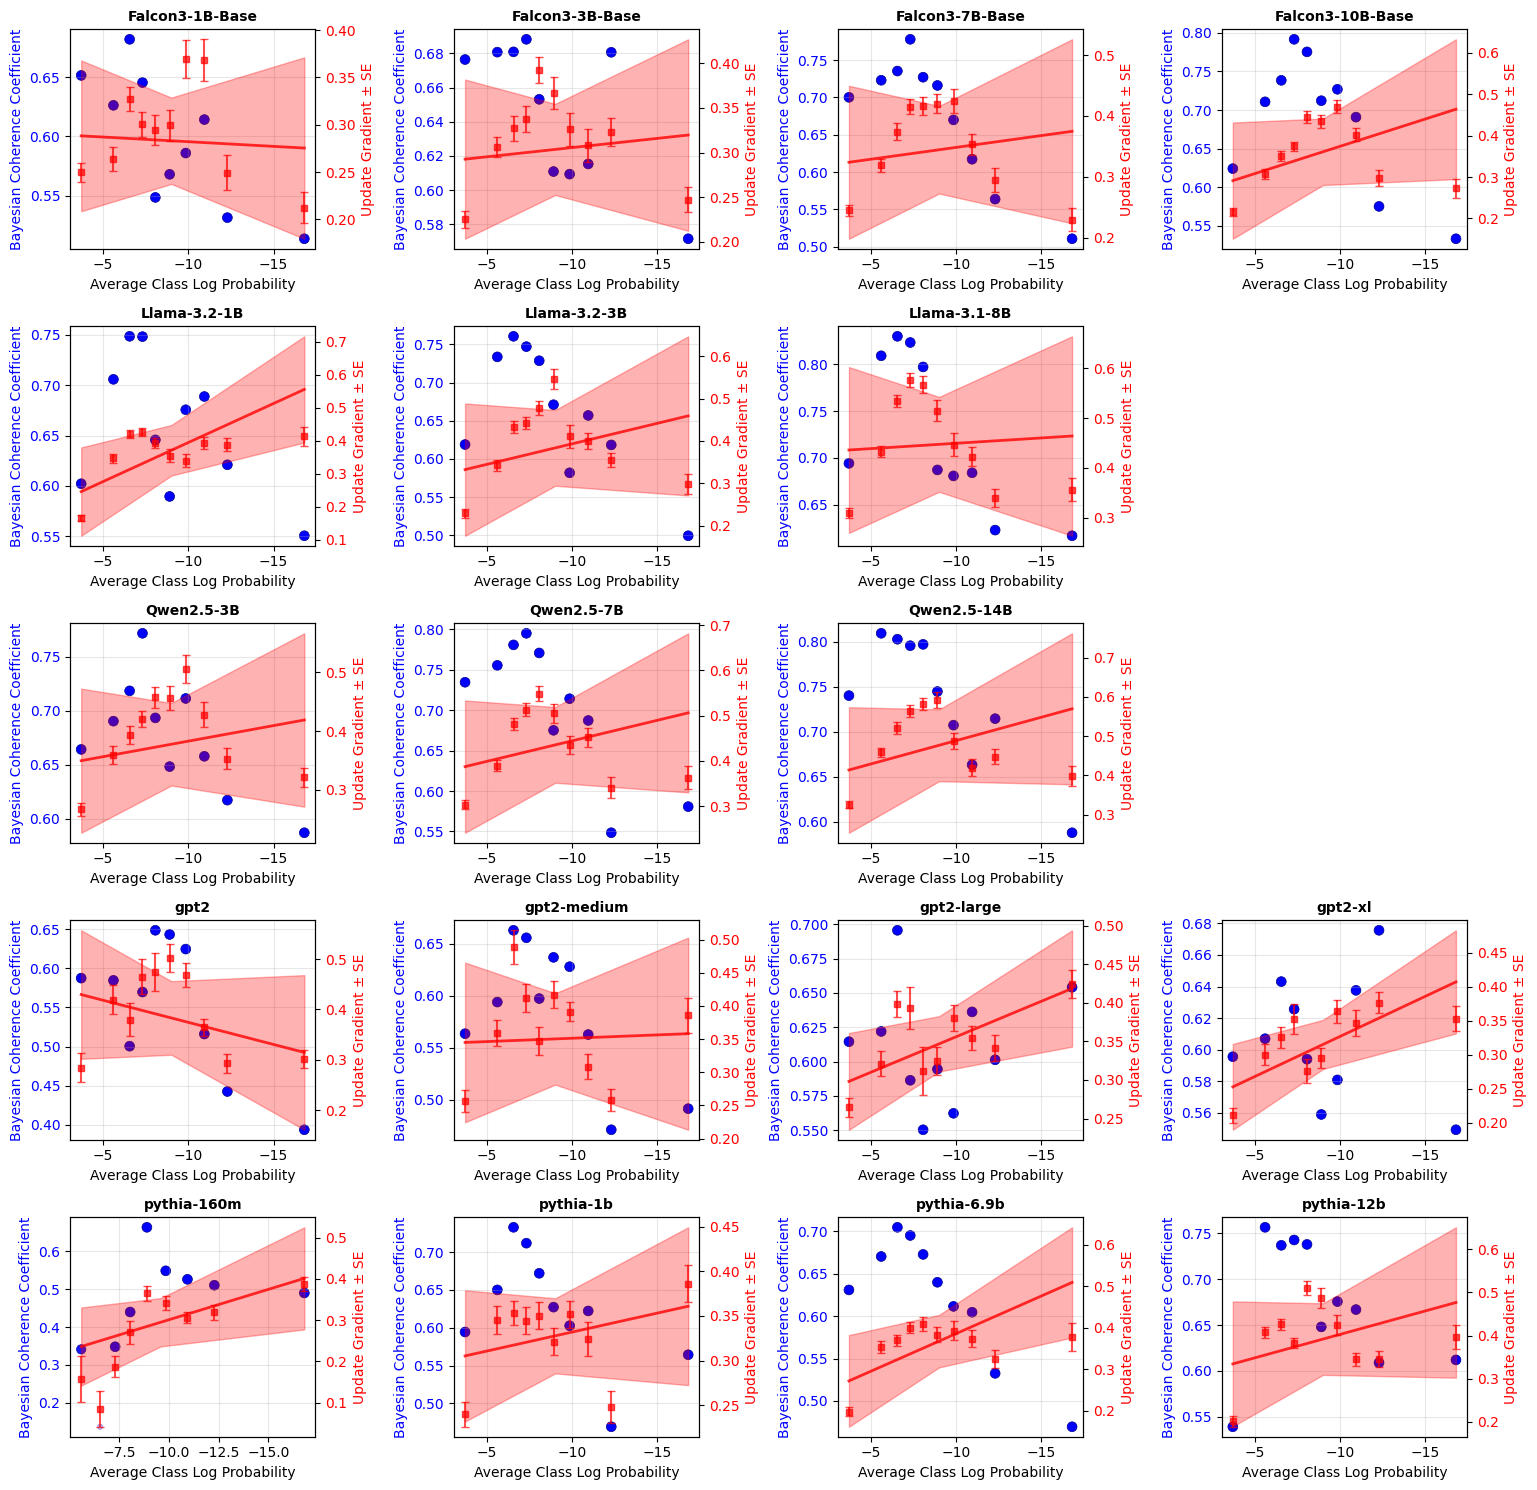

In [22]:
# Create the subplot grid
fig, axes = plt.subplots(n_rows, n_cols, figsize=(4*n_cols, 3*n_rows))
if n_rows == 1:
    axes = axes.reshape(1, -1)
elif n_cols == 1:
    axes = axes.reshape(-1, 1)

def add_weighted_trend_with_uncertainty(ax, x, y, yerr, color, alpha=0.3):
    """Add a weighted trend line with uncertainty band based on individual point uncertainties."""
    if len(x) < 2:
        return
    
    # Weight points inversely by their uncertainty (lower uncertainty = higher weight)
    weights = 1.0 / (yerr + 1e-8)  # Add small epsilon to avoid division by zero
    
    # Fit weighted linear regression
    try:
        # Use weighted polyfit
        z = np.polyfit(x, y, 1, w=weights)
        trend_func = np.poly1d(z)
        
        # Create smooth x range for trend line
        x_smooth = np.linspace(x.min(), x.max(), 100)
        y_trend = trend_func(x_smooth)
        
        # Calculate prediction interval based on residuals and weights
        y_pred = trend_func(x)
        residuals = y - y_pred
        weighted_mse = np.sum(weights * residuals**2) / np.sum(weights)
        
        # Estimate uncertainty band (conservative approach)
        uncertainty_band = np.sqrt(weighted_mse) * (1 + 0.5 * np.abs(x_smooth - np.mean(x)) / np.std(x))
        
        # Plot trend line and uncertainty band
        ax.plot(x_smooth, y_trend, color=color, linewidth=2, alpha=0.8, label='Weighted trend')
        ax.fill_between(x_smooth, y_trend - uncertainty_band, y_trend + uncertainty_band, 
                       color=color, alpha=alpha, label='Uncertainty band')
        
        return z[0]  # Return slope
    except:
        return None

current_row = 0

# Plot all model families (same structure as other analyses)
for family in model_families_plot.keys():
    models = model_families_plot[family]["Final"]
    
    for col_idx, model in enumerate(models):
        ax1 = axes[current_row, col_idx]
        ax2 = ax1.twinx()  # Create secondary y-axis
        
        # Get data for this model
        model_data = avg_class_df[avg_class_df["Language Model"] == model]
        
        if not model_data.empty:
            # Plot BCC on primary y-axis with point styling based on p-value significance
            p_values = model_data["p_value"]
            point_sizes = 15 + 35 * (1 - np.clip(p_values / 0.05, 0, 1))  # 15-50 size range
            point_alphas = 0.3 + 0.7 * (1 - np.clip(p_values / 0.05, 0, 1))  # 0.3-1.0 alpha range
            
            # Create a scatter plot with varying size and alpha based on significance
            ax1.scatter(model_data["avg_class_log_probability_midpoint"], 
                      model_data["Bayesian Coherence Coefficient"],
                      s=point_sizes, alpha=point_alphas, color='blue',
                      label='BCC (size/alpha=significance)', edgecolors='darkblue', linewidth=0.5)
            
            # Plot Update Gradient with error bars on secondary y-axis
            ax2.errorbar(model_data["avg_class_log_probability_midpoint"], 
                       model_data["Update Gradient"],
                       yerr=model_data["slope_stderr"],
                       fmt='s', color='red', alpha=0.7, markersize=5, 
                       capsize=3, capthick=1, label='Gradient ± SE')
            
            # Add trend lines if enough points
            if len(model_data) > 1:
                # # BCC trend line weighted by statistical significance (lower p-value = higher weight)
                # bcc_weights = 1.0 / (model_data["p_value"] + 1e-99)  # Avoid division by zero
                # z1 = np.polyfit(model_data["avg_class_log_probability_midpoint"], 
                #               model_data["Bayesian Coherence Coefficient"], 1, w=bcc_weights)
                # p1 = np.poly1d(z1)
                # x_trend = np.linspace(model_data["avg_class_log_probability_midpoint"].min(), 
                #                     model_data["avg_class_log_probability_midpoint"].max(), 100)
                # ax1.plot(x_trend, p1(x_trend), "b--", alpha=0.8, linewidth=1,
                #        label='Significance-weighted trend')
                
                # Weighted trend for Update Gradient (incorporating uncertainty)
                slope = add_weighted_trend_with_uncertainty(
                    ax2, 
                    model_data["avg_class_log_probability_midpoint"].values, 
                    model_data["Update Gradient"].values,
                    model_data["slope_stderr"].values,
                    'red'
                )
            
            # Calculate correlations
            corr_bcc = model_data["avg_class_log_probability_midpoint"].corr(model_data["Bayesian Coherence Coefficient"])
            corr_grad = model_data["avg_class_log_probability_midpoint"].corr(model_data["Update Gradient"])
            
            ax1.set_title(f"{model}", fontsize=10, fontweight='bold')
        else:
            ax1.text(0.5, 0.5, f"No data\n{model}", 
                   transform=ax1.transAxes, ha='center', va='center')
            ax1.set_title(f"{model}", fontsize=10)
        
        ax1.set_xlabel('Average Class Log Probability')
        ax1.set_ylabel('Bayesian Coherence Coefficient', color='blue')
        ax2.set_ylabel('Update Gradient ± SE', color='red')
        ax1.tick_params(axis='y', labelcolor='blue')
        ax2.tick_params(axis='y', labelcolor='red')
        ax1.grid(True, alpha=0.3)
        
        # Invert x-axis so higher (less negative) class probabilities are on the left
        ax1.invert_xaxis()
    
    # Hide unused subplots in this row
    for empty_idx in range(len(models), n_cols):
        axes[current_row, empty_idx].set_visible(False)
    
    current_row += 1

plt.tight_layout()
plt.subplots_adjust(left=0.08)

# Save the figure
plt.savefig('results/plots/bcc_vs_avg_class_log_probability.png', dpi=300, bbox_inches='tight')
plt.show()

In [23]:
# Display summary statistics for the avg class log probability analysis
print("Summary statistics for Average Class Log Probability analysis:")
print("="*60)

print(f"\nRange of average class log probabilities:")
print(f"Min: {avg_class_df['avg_class_log_probability_midpoint'].min():.3f}")
print(f"Max: {avg_class_df['avg_class_log_probability_midpoint'].max():.3f}")
print(f"Mean: {avg_class_df['avg_class_log_probability_midpoint'].mean():.3f}")
print(f"Std: {avg_class_df['avg_class_log_probability_midpoint'].std():.3f}")

print(f"\nBayesian Coherence Coefficient statistics:")
print(f"Min: {avg_class_df['Bayesian Coherence Coefficient'].min():.3f}")
print(f"Max: {avg_class_df['Bayesian Coherence Coefficient'].max():.3f}")
print(f"Mean: {avg_class_df['Bayesian Coherence Coefficient'].mean():.3f}")
print(f"Std: {avg_class_df['Bayesian Coherence Coefficient'].std():.3f}")

print(f"\nModels with strongest correlations between avg_class_log_probability and BCC:")
correlations = []
for model in avg_class_df['Language Model'].unique():
    model_data = avg_class_df[avg_class_df['Language Model'] == model]
    if len(model_data) > 2:  # Need at least 3 points for meaningful correlation
        corr = model_data['avg_class_log_probability_midpoint'].corr(model_data['Bayesian Coherence Coefficient'])
        if not pd.isna(corr):
            correlations.append((model, corr, len(model_data)))

correlations.sort(key=lambda x: abs(x[1]), reverse=True)
for model, corr, n_points in correlations[:5]:
    print(f"  {model}: r = {corr:.3f} (n = {n_points})")

print(f"\nNumber of significant BCC correlations (p < 0.05): {(avg_class_df['p_value'] < 0.05).sum()}")
print(f"Percentage significant: {(avg_class_df['p_value'] < 0.05).mean()*100:.1f}%")

print("\n" + "="*60)
print("COMPARISON ACROSS ALL THREE ANALYSES:")
print("="*60)
print("1. Evidence Length (likelihood_num_tokens): Discrete bins based on token count")
print("2. Average Evidence Log Likelihood: Magnitude of evidence likelihood")
print("3. Average Class Log Probability: Overall magnitude of class probabilities")
print("\nEach analysis provides insights into different aspects of Bayesian reasoning:")
print("- Evidence length: How reasoning scales with evidence complexity")
print("- Likelihood magnitude: How reasoning varies with evidence strength")
print("- Class probability magnitude: How reasoning varies with overall certainty levels")


Summary statistics for Average Class Log Probability analysis:

Range of average class log probabilities:
Min: -16.806
Max: -3.712


TypeError: 'Categorical' with dtype category does not support reduction 'mean'